In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
exp_name = "exp_compass"
exp_number = "exp_debug"
base_path = "/Users/andreasathanasopoulos/Phd/projects/bayesian_fairness/"
data_path = base_path + "/my_code/Bayesian-fairness/data"
save_path = base_path + f"/my_code/Bayesian-fairness/results/continuous/{exp_name}/{exp_number}"

# load data


In [3]:
def encode_data(data,unique_values):
    encoded_value = np.array([])
    for i, d in data.iterrows():
        # encode feature to an index represents the unique value.
        index = np.argmax((d.values == unique_values).all(axis=1))
        encoded_value = np.append(encoded_value, index)
    return encoded_value.astype(int)

In [4]:
# set atributes
Z_atr = ["sex", "race"]
X_atr = ['age_cat', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree']
Y_atr = 'two_year_recid'

# clip_features = ["juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count"]

In [5]:
dataset = pd.read_csv(data_path + "/compas.csv")

In [6]:
# get distinct values
unique_z = np.unique(dataset[Z_atr].values, axis=0)
n_z = len(unique_z)

unique_y = np.unique(dataset[Y_atr].values, axis=0)
n_y = len(unique_y)

unique_x = np.unique(dataset[X_atr].values, axis=0)
n_x = len(unique_x)

In [7]:
print("Unique Z values:", n_z)
print("Unique X values:", n_x)
print("Unique Y values:", n_y)

Unique Z values: 12
Unique X values: 604
Unique Y values: 2


In [8]:
# # encode z for convenience
dataset["z"] = encode_data(dataset[Z_atr], unique_values=unique_z)
Z_atr = "z"
# # # drop under represented index
# n_z = n_z - 1
# mask = np.logical_not(dataset[Z_atr] == 10)
# dataset = dataset[mask]

In [9]:
dataset = dataset.astype("float32")

In [10]:
# maks_11 = dataset[Z_atr] == 11
# dataset.loc[maks_11,Z_atr] = 10 

In [11]:
# dataset.reset_index(inplace=True)

In [12]:
# unique_z = dataset["z"].unique()
# unique_z

In [13]:
# from sklearn.model_selection import StratifiedShuffleSplit
# train_size = 6000/dataset.shape[0]
# spliter = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=0)

In [14]:
# dataset = dataset.sample(frac=1,replace=False,ignore_index=True)

In [15]:
train_data = dataset.iloc[0:6000]
test_data = dataset.iloc[6000:]

In [16]:
# tmp = train_data.copy()
# train_data = test_data.copy()
# test_data = tmp

In [17]:
print("training size:", train_data.shape)
print("testing size:", test_data.shape)

training size: (6000, 10)
testing size: (1214, 10)


# model

In [18]:
def calc_freq(data, n):
    """ calculate frequency of 1D array"""
    P = np.zeros(n)
    for value in range(n):
        mask =  data == value
        P[value] = mask.mean()
    return P

def get_models(data):
    # Py, Pz_y
    N_y = np.zeros(n_y) + 0.001# 0.5
    N_z_y = np.zeros((n_z,n_y)) + 0.001 #0.5
    for i, datum in data.iterrows():
        N_y[int(datum[Y_atr])] += 1
        N_z_y[int(datum[Z_atr]),int(datum[Y_atr])] += 1
    Py = N_y / np.sum(N_y)
    Pz_y = N_z_y/ np.sum(N_z_y, axis=0)
    
    # Py_x
    from sklearn.linear_model import LogisticRegression
    model_y_x = LogisticRegression(max_iter=1000)
    model_y_x.fit(X = data[X_atr], y = data[Y_atr])
    
    #Pz_yx
    unique_z_values = data[Z_atr].unique()
    missing_z = [z for z in range(12) if z not in unique_z_values]

    if missing_z:
        random_data = np.random.randint(low= 0 , high=2, size = (1, len(data.columns)))
        fake_df = pd.DataFrame(random_data,columns = data.columns)
        fake_df[Z_atr] = missing_z
        data = pd.concat([data, fake_df])
        print(missing_z)
    input_features = [Y_atr] + X_atr
    model_z_yx = LogisticRegression(max_iter=1000)
    model_z_yx.fit(X = data[input_features], y = data[Z_atr])
    
    return Py, Pz_y, model_y_x, model_z_yx

In [19]:
test_data[Z_atr].unique()

array([ 1.,  0.,  2.,  3.,  8.,  7.,  9.,  5.,  6., 11.,  4.],
      dtype=float32)

In [20]:
test_model = get_models(test_data)

[10]


# Train policy

In [21]:
num_X = n_x # number of features
num_Y = n_y # number of outcomes
num_Z = n_z # number of sensitive features
num_A = 2 # number of actions

In [22]:
# parameters
n_iter = 400 # number of itteration for SGD
lr = 1.0 # learning rate
l = 0.5 # lambda

# Functions

In [23]:
def get_eye_utility(size):
    return np.eye(size)

utility = get_eye_utility(size=2)

# Algorithm
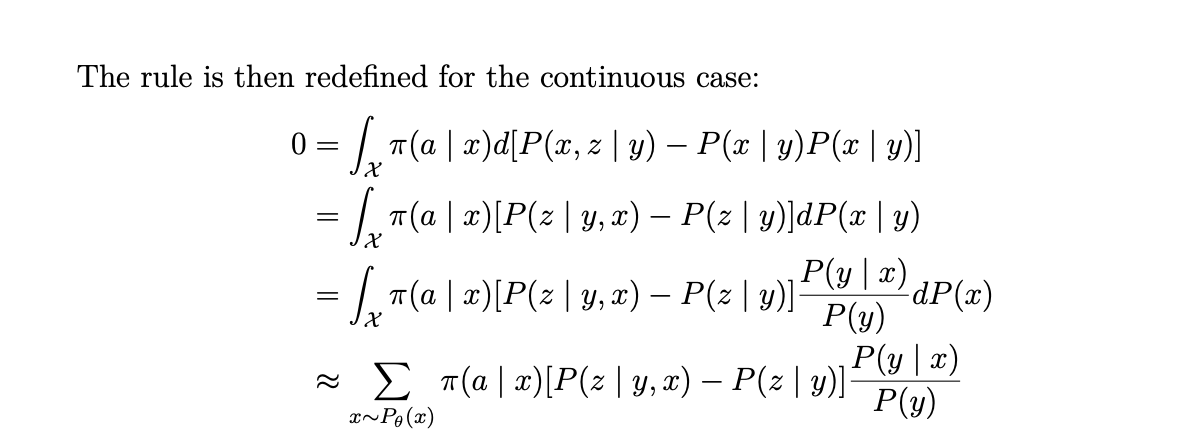

In [24]:
def get_fairness_loss(Pa_x, Py, Pz_y, Py_x, Pz_yx):
    # compute delta
    term_1 = Pz_yx  - tf.expand_dims(Pz_y, axis=-1) # ok
    term_2 = Py_x / tf.expand_dims(Py,axis=-1) # ok
    delta = term_1 * tf.expand_dims(term_2, axis=0) # ok
    
    # compute c
    exp_Pa_x = tf.expand_dims(tf.expand_dims(Pa_x, axis=0),axis=0)
    exp_delta = tf.expand_dims(delta, axis=-1)
    c = tf.linalg.matmul(exp_Pa_x,
                         exp_delta)
    
    # compute fairness
    fairness = tf.norm(c, ord=1) / Py_x.shape[1]
    return fairness

# def get_fairness_loss(Pa_x, Py, Pz_y, Py_x, Pz_yx):
#     # compute delta
#     term_1 = Pz_yx  - tf.expand_dims(Pz_y, axis=-1) # ok
#     term_2 = Py_x / tf.expand_dims(Py,axis=-1) # ok
#     delta = term_1 * tf.expand_dims(term_2, axis=0) # ok
    
#     # compute c
#     exp_Pa_x = tf.expand_dims(tf.expand_dims(Pa_x, axis=0),axis=0)
#     exp_delta = tf.expand_dims(delta, axis=-1)
#     c = tf.linalg.matmul(exp_Pa_x,
#                          exp_delta)
    
#     # compute fairness
#     fairness = tf.norm(c, ord=1) / Py_x.shape[1]
#     return fairness

In [25]:
def get_utility_loss(y_true, y_pred):
    utility = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    neg_utility = - utility
    return tf.math.reduce_mean(neg_utility)

In [26]:
def get_utility_metric(y_true, y_pred):
    utility = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    return tf.math.reduce_mean(utility)

In [61]:
import tensorflow as tf
from tensorflow.python.keras.engine import data_adapter

utility_tracker = tf.keras.metrics.Mean(name="utility")
fairness_tracker = tf.keras.metrics.Mean(name="fairness")
loss_tracker = tf.keras.metrics.Mean(name="loss")

eval_utility_tracker = tf.keras.metrics.Mean(name="eval_utility")
eval_fairness_tracker = tf.keras.metrics.Mean(name="eval_fairness")
eval_loss_tracker = tf.keras.metrics.Mean(name="eval_loss")


class LogisticRegresionTF(tf.keras.Model):
    """
    logistic regresion model , tensorflow
    """
    def __init__(self, input_dim, l):
        super(LogisticRegresionTF, self).__init__()
        self.l = l
        
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(input_dim, 1), dtype="float32"),
            trainable=True,
        )
        
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(
            initial_value=b_init(shape=(), dtype="float32"),
            trainable=True
        )

    def call(self, inputs):
        return tf.nn.sigmoid(tf.matmul(inputs,self.w) + self.b)

In [62]:
def get_models_from_data(data):
    # get Py, Pz_y and models for Py_x & Pz_yx
    Py, Pz_y, model_y_x, model_z_yx = get_models(data)
    
    # get Py_x from data
    Py_x = model_y_x.predict_proba(data[X_atr]).T
    
    # get Pz_yx from data
    Pz_yx = np.zeros((n_z, n_y, data.shape[0]))
    for y in range(n_y):
        tmp_data = data[[Y_atr] + X_atr].copy()
        tmp_data[Y_atr] = y
        Pz_yx[:,y,:] = model_z_yx.predict_proba(tmp_data[[Y_atr] + X_atr]).T
    return Py, Pz_y, Py_x, Pz_yx

In [63]:
policy_model = LogisticRegresionTF(input_dim=len(X_atr), l = 0.0)
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)

In [64]:
train_model = get_models_from_data(train_data)
Py, Pz_y, Py_x, Pz_yx = train_model

In [65]:
epochs = 400

In [66]:
@tf.function
def train_step(policy, data, lamba_parameter, optimizer):
    x, y, Py, Pz_y, Py_x, Pz_yx = data
    # Run forward pass.
    with tf.GradientTape() as tape:
        y_pred = policy(x, training=True)
        utility = get_utility_loss(y_true = y, y_pred = y_pred)
        Pa_x = tf.stack([1 - y_pred, y_pred])
        Pa_x = tf.squeeze(Pa_x, axis=-1, name=None)
        fairness = get_fairness_loss(Pa_x, Py, Pz_y, Py_x, Pz_yx)
        loss = (1-lamba_parameter) * utility + lamba_parameter * fairness 

    # Run backwards pass.
    optimizer.minimize(loss, policy.trainable_variables, tape=tape)
    # update metrics
    loss_tracker.update_state(loss)
    utility_tracker.update_state(get_utility_metric(y_true = y, y_pred = y_pred))
    fairness_tracker.update_state(fairness)

    metrics = {}
    metrics["fairness_loss"] = fairness_tracker.result()
    metrics["utility"] = utility_tracker.result()
    metrics["loss"] = loss_tracker.result()
    return metrics

In [68]:
@tf.function
def eval_step(policy, data, lamba_parameter):
    x, y, Py, Pz_y, Py_x, Pz_yx = data
    
    y_pred = policy(x, training=False)
    utility = get_utility_metric(y_true = y, y_pred = y_pred)
    Pa_x = tf.stack([1 - y_pred, y_pred])
    Pa_x = tf.squeeze(Pa_x, axis=-1, name=None)
    fairness = get_fairness_loss(Pa_x, Py, Pz_y, Py_x, Pz_yx)
    loss = (1-lamba_parameter) * utility - lamba_parameter * fairness 

    # update metrics
    eval_loss_tracker.update_state(loss)
    eval_utility_tracker.update_state(get_utility_metric(y_true = y, y_pred = y_pred))
    eval_fairness_tracker.update_state(fairness)

    metrics = {}
    metrics["fairness_loss"] = eval_fairness_tracker.result()
    metrics["utility"] = eval_utility_tracker.result()
    metrics["loss"] = eval_loss_tracker.result()
    return metrics

In [69]:
def reset_trackers(trackers):
    for tracker in trackers:
        tracker.reset_states()

In [70]:
policy_model.get_weights()

[array([[ 0.01229399],
        [-0.06168405],
        [-0.0492089 ],
        [ 0.01911793],
        [-0.07370343],
        [ 0.04405285]], dtype=float32),
 0.0]

In [71]:
loss_tracker = tf.keras.metrics.Mean(name="loss")
utility_tracker = tf.keras.metrics.Mean(name="utility")
fairness_tracker = tf.keras.metrics.Mean(name="fairness")

# train data
train_model = get_models_from_data(train_data)
Py, Pz_y, Py_x, Pz_yx = train_model

x = tf.convert_to_tensor(train_data[X_atr].values)
y = tf.reshape(tf.convert_to_tensor(train_data[Y_atr].values),(-1,1))

# test data
test_model = get_models_from_data(test_data)
test_tf_Py, test_tf_Pz_y, test_tf_Py_x, test_tf_Pz_yx = (tf.convert_to_tensor(p, dtype="float32") for p in test_model)
test_x = tf.convert_to_tensor(test_data[X_atr].values)
test_y = tf.reshape(tf.convert_to_tensor(test_data[Y_atr].values),(-1,1))
test_data_list = (test_x, test_y, test_tf_Py, test_tf_Pz_y, test_tf_Py_x, test_tf_Pz_yx)


# loop
history = []
eval_history = []
for epoch in range(epochs):
    tf_Py, tf_Pz_y, tf_Py_x, tf_Pz_yx = (tf.convert_to_tensor(p, dtype="float32") for p in train_model)
    
    # training step
    step_results = train_step(policy = policy_model,
                              data = (x, y, tf_Py, tf_Pz_y, tf_Py_x, tf_Pz_yx),
                              lamba_parameter = 0.3,
                              optimizer = optimizer)
    step_results = {key:step_results[key].numpy() for key in step_results.keys()}
    history += [step_results]
    
    # evaluation step
    
    eval_results = eval_step(policy = policy_model,
                             data = test_data_list,
                             lamba_parameter = 0.3)
    
    eval_history +=[eval_results]
    
    
    reset_trackers([loss_tracker, utility_tracker, fairness_tracker,
                    eval_loss_tracker, eval_utility_tracker, eval_fairness_tracker])
    print(f"--- Step : {epoch + 1} \n  ------- {step_results}")

[10]
--- Step : 1 
  ------- {'fairness_loss': 0.06459948, 'utility': 0.48218587, 'loss': -0.31815025}
--- Step : 2 
  ------- {'fairness_loss': 0.041350007, 'utility': 0.48876864, 'loss': -0.32973304}
--- Step : 3 
  ------- {'fairness_loss': 0.009334523, 'utility': 0.49822283, 'loss': -0.34595564}
--- Step : 4 
  ------- {'fairness_loss': 0.028393222, 'utility': 0.5068072, 'loss': -0.34624705}
--- Step : 5 
  ------- {'fairness_loss': 0.019960308, 'utility': 0.5046947, 'loss': -0.3472982}
--- Step : 6 
  ------- {'fairness_loss': 0.011500819, 'utility': 0.5024974, 'loss': -0.34829792}
--- Step : 7 
  ------- {'fairness_loss': 0.0074838116, 'utility': 0.50051326, 'loss': -0.3481141}
--- Step : 8 
  ------- {'fairness_loss': 0.019120764, 'utility': 0.50492144, 'loss': -0.34770876}
--- Step : 9 
  ------- {'fairness_loss': 0.010498031, 'utility': 0.502691, 'loss': -0.34873426}
--- Step : 10 
  ------- {'fairness_loss': 0.007506686, 'utility': 0.5005575, 'loss': -0.3481382}
--- Step : 11

--- Step : 116 
  ------- {'fairness_loss': 0.015250468, 'utility': 0.515155, 'loss': -0.35603338}
--- Step : 117 
  ------- {'fairness_loss': 0.01473285, 'utility': 0.5149547, 'loss': -0.3560484}
--- Step : 118 
  ------- {'fairness_loss': 0.020589247, 'utility': 0.51718444, 'loss': -0.35585234}
--- Step : 119 
  ------- {'fairness_loss': 0.015857205, 'utility': 0.5156558, 'loss': -0.3562019}
--- Step : 120 
  ------- {'fairness_loss': 0.015135437, 'utility': 0.515454, 'loss': -0.35627717}
--- Step : 121 
  ------- {'fairness_loss': 0.0147993285, 'utility': 0.51525736, 'loss': -0.35624033}
--- Step : 122 
  ------- {'fairness_loss': 0.021432336, 'utility': 0.51780844, 'loss': -0.3560362}
--- Step : 123 
  ------- {'fairness_loss': 0.016565092, 'utility': 0.5162797, 'loss': -0.35642624}
--- Step : 124 
  ------- {'fairness_loss': 0.015841208, 'utility': 0.51607645, 'loss': -0.35650113}
--- Step : 125 
  ------- {'fairness_loss': 0.015207142, 'utility': 0.51587844, 'loss': -0.35655275}


--- Step : 237 
  ------- {'fairness_loss': 0.020341747, 'utility': 0.5263702, 'loss': -0.36235663}
--- Step : 238 
  ------- {'fairness_loss': 0.02066309, 'utility': 0.5265774, 'loss': -0.36240527}
--- Step : 239 
  ------- {'fairness_loss': 0.021007588, 'utility': 0.526784, 'loss': -0.36244652}
--- Step : 240 
  ------- {'fairness_loss': 0.020707771, 'utility': 0.52672434, 'loss': -0.3624947}
--- Step : 241 
  ------- {'fairness_loss': 0.021048788, 'utility': 0.5269299, 'loss': -0.3625363}
--- Step : 242 
  ------- {'fairness_loss': 0.020753652, 'utility': 0.526871, 'loss': -0.3625836}
--- Step : 243 
  ------- {'fairness_loss': 0.021181202, 'utility': 0.5271126, 'loss': -0.36262447}
--- Step : 244 
  ------- {'fairness_loss': 0.020881958, 'utility': 0.5270535, 'loss': -0.36267284}
--- Step : 245 
  ------- {'fairness_loss': 0.021312442, 'utility': 0.52729404, 'loss': -0.3627121}
--- Step : 246 
  ------- {'fairness_loss': 0.021014128, 'utility': 0.5272346, 'loss': -0.36275998}
--- S

--- Step : 350 
  ------- {'fairness_loss': 0.023156697, 'utility': 0.53384537, 'loss': -0.36674473}
--- Step : 351 
  ------- {'fairness_loss': 0.022843847, 'utility': 0.53376496, 'loss': -0.3667823}
--- Step : 352 
  ------- {'fairness_loss': 0.023198012, 'utility': 0.53395754, 'loss': -0.36681086}
--- Step : 353 
  ------- {'fairness_loss': 0.022884622, 'utility': 0.53387755, 'loss': -0.3668489}
--- Step : 354 
  ------- {'fairness_loss': 0.02261262, 'utility': 0.5338012, 'loss': -0.36687705}
--- Step : 355 
  ------- {'fairness_loss': 0.022934964, 'utility': 0.5339925, 'loss': -0.36691427}
--- Step : 356 
  ------- {'fairness_loss': 0.022659922, 'utility': 0.5339164, 'loss': -0.3669435}
--- Step : 357 
  ------- {'fairness_loss': 0.02298525, 'utility': 0.534107, 'loss': -0.36697933}
--- Step : 358 
  ------- {'fairness_loss': 0.022707153, 'utility': 0.5340313, 'loss': -0.36700973}
--- Step : 359 
  ------- {'fairness_loss': 0.0230355, 'utility': 0.53422105, 'loss': -0.3670441}
--- 

In [72]:
policy_model.get_weights()

[array([[-0.45740572],
        [-0.06359027],
        [-0.09031927],
        [ 0.17761113],
        [ 0.00795154],
        [-0.3536475 ]], dtype=float32),
 -0.6285769]

In [73]:
history_df = pd.DataFrame(history)
eval_history_df = pd.DataFrame(eval_history)

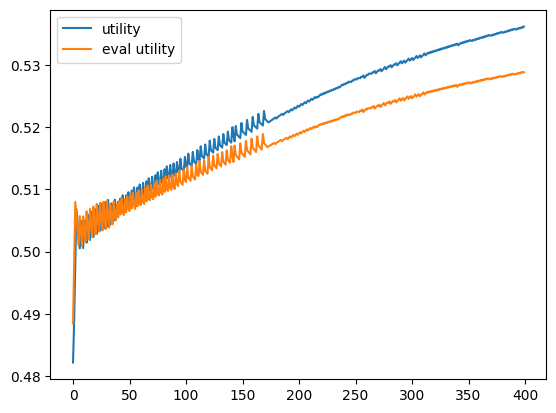

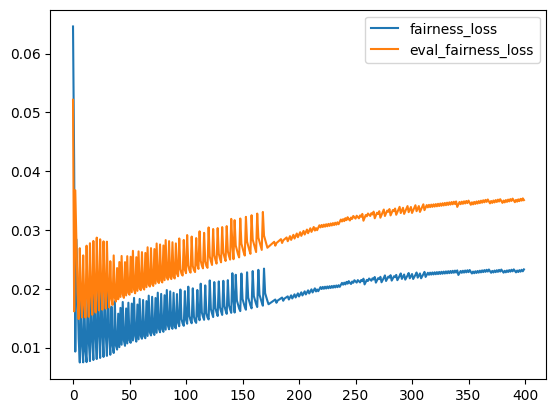

In [74]:
plt.figure()
plt.plot(history_df["utility"],label="utility")
plt.plot(eval_history_df["utility"],label="eval utility")
plt.legend()
plt.show()

plt.figure()
plt.plot(history_df["fairness_loss"],label="fairness_loss")
plt.plot(eval_history_df["fairness_loss"],label="eval_fairness_loss")
plt.legend()
plt.show()

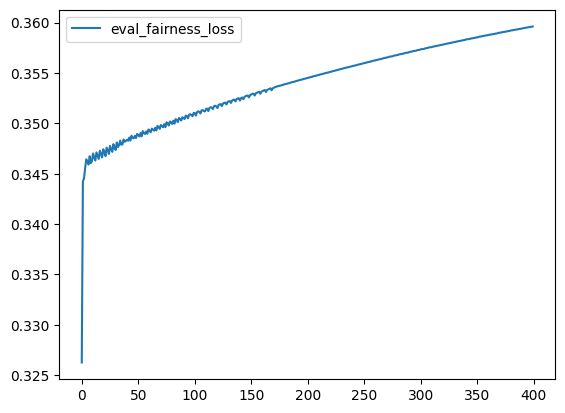

In [75]:
plt.figure()
plt.plot(eval_history_df["loss"],label="eval_fairness_loss")
plt.legend()
plt.show()

# empirical fairness

In [91]:
def empirical_fairness_cont_v11(datas, p_a_x, Pz_y, Py, model_y_x, model_z_yx):
    Z = n_z

    Py_x = model_y_x.predict_proba(datas[X_atr]).T
    EF = 0
    for y in range(2):
        tmp_data = datas[[Y_atr] + X_atr].copy()
        tmp_data[Y_atr] = y
        Pz_yx = model_z_yx.predict_proba(tmp_data[[Y_atr] + X_atr]).T
        print(Pz_yx.shape)
        for z in range(Z):
            c = 0
            for i in range(tmp_data.shape[0]):
                delta = (Pz_yx[z, i] - Pz_y[z, y] ) * (Py_x[y, i]/Py[y])
                c += p_a_x[:, i] * delta
            c = c/tmp_data.shape[0]
            c = np.linalg.norm(c, 1)
            EF += c
    return EF


def empirical_fairness_cont_v12(datas, p_a_x, Pz_y, Py,model_y_x, model_z_yx):
    Z = n_z

    Py_x = model_y_x.predict_proba(datas[X_atr]).T
    EF = 0
    for y in range(2):
        tmp_data = datas[[Y_atr] + X_atr].copy()
        tmp_data[Y_atr] = y
        Pz_yx = model_z_yx.predict_proba(tmp_data[[Y_atr] + X_atr]).T
        for z in range(Z):
            c = 0
            j= 0 
            for i in range(tmp_data.shape[0]):
                j = j + 1
                delta = (Pz_yx[z, i] / Pz_y[z, y] - 1 ) * (Py_x[y, i] / (Py[y]) )
                c += p_a_x[:, i] * delta
            c = c/datas.shape[0]
            c = np.linalg.norm(c, 1)
            EF += c
    return EF

In [92]:
datas= test_data

In [93]:
p_a1 = policy_model.predict(datas[X_atr].astype("float32"))
p_a0 = 1 - p_a1
p_a_x = np.concatenate([p_a0, p_a1],axis=1).T

38/38 [==============================] - 0s 334us/step


In [94]:
Py, Pz_y, model_y_x, model_z_yx = get_models(datas)
empirical_fairness_cont_v11(datas = datas,
                            p_a_x = p_a_x,
                            Pz_y=Pz_y,
                            Py=Py,
                            model_y_x = model_y_x,
                            model_z_yx = model_z_yx )

[10]
(12, 1214)
(12, 1214)


0.026684682292398065

In [95]:
Py, Pz_y, model_y_x, model_z_yx = get_models(datas)
empirical_fairness_cont_v12(datas = datas,
                            p_a_x = p_a_x,
                            Pz_y = Pz_y,
                            Py = Py,
                            model_y_x = model_y_x, 
                            model_z_yx = model_z_yx )

[10]


3.21051122690551

# vectorize implementation

function dependence = Fairness(policy, model, model_delta)
  A = rows(policy);
  X = columns(policy);
  dependence = 0;
  for y=1:model.Y
	for z=1:model.Z
	  delta = policy * model_delta(:, y, z);
	  dependence += norm(delta, 1);
	end
  end
end

In [167]:
train_model = get_models_from_data(train_data)
Py, Pz_y, Py_x, Pz_yx = train_model

In [168]:
Py.shape, Pz_y.shape, Py_x.shape, Pz_yx.shape

((2,), (12, 2), (2, 6000), (12, 2, 6000))

In [169]:
z=10
y=1

In [172]:
Pa1 = policy_model.predict(train_data[X_atr])
p_a0 = 1 - Pa1
P_a_x = np.concatenate([p_a0, Pa1],axis=1).T
tf_P_a_x = tf.convert_to_tensor(P_a_x)

188/188 [==============================] - 0s 252us/step


In [173]:
Py.shape, Pz_y.shape, Py_x.shape, Pz_yx.shape, P_a_x.shape

((2,), (12, 2), (2, 6000), (12, 2, 6000), (2, 6000))

In [174]:
# rshaped = np.reshape(Pz_yx
n1 = (Pz_yx / np.expand_dims(Pz_y,axis=-1) - 1)# ok

n2 = Py_x / np.expand_dims(Py,axis=-1) # ok
delta_v = n1 * np.expand_dims(n2,axis=0) # ok

In [175]:
# tf delta ok
n1_tf = (tf_Pz_yx / tf.expand_dims(tf_Pz_y, axis=-1)) - 1 # ok
n2_tf = tf_Py_x / tf.expand_dims(tf_Py,axis=-1) # ok
delta_tf = n1_tf * tf.expand_dims(n2_tf, axis=0) # ok
np.all(delta_tf.numpy() == delta_v)# 

False

In [176]:
delta_tf.shape, tf_P_a_x.shape

(TensorShape([12, 2, 6000]), TensorShape([2, 6000]))

In [185]:
tf_P_a_x = tf.cast(tf_P_a_x,"float32")

In [178]:
tf.linalg.matmul(tf_P_a_x, tf.expand_dims(delta_tf[z,y,:],axis=-1))

InvalidArgumentError: cannot compute MatMul as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:MatMul]

In [179]:
np.expand_dims(tf_P_a_x,axis=[0,1]).shape, np.expand_dims(delta_tf,axis=-1).shape

((1, 1, 2, 6000), (12, 2, 6000, 1))

In [180]:
c = tf.linalg.matmul(np.expand_dims(tf_P_a_x,axis=[0,1]), np.expand_dims(delta_tf,axis=-1))

In [181]:
fairness = tf.norm(c, ord=1, axis=None, keepdims=None, name=None) / 6000
fairness

<tf.Tensor: shape=(), dtype=float64, numpy=1.6916529494858994>

In [186]:
def tf_fairness(Pa_x, Py, Pz_y, Py_x, Pz_yx):
    # compute delta
    term_1 = (tf_Pz_yx / tf.expand_dims(tf_Pz_y, axis=-1)) - 1 # ok
    term_2 = tf_Py_x / tf.expand_dims(tf_Py,axis=-1) # ok
    delta = term_1 * tf.expand_dims(term_2, axis=0) # ok
    
    # compute c
    c = tf.linalg.matmul(tf.expand_dims(tf.expand_dims(Pa_x, axis=0),axis=0),
                         tf.expand_dims(delta, axis=-1))
    
    # compute fairness
    fairness = tf.norm(c, ord=1, axis=None, keepdims=None, name=None) / 6000
    return fairness

In [187]:
tf_fairness(tf_P_a_x, tf_Py, tf_Pz_y, tf_Py_x, tf_Pz_yx)

<tf.Tensor: shape=(), dtype=float32, numpy=1.691653>

In [ ]:
tf_P_a_x

In [68]:
delta_tf[z,y,:]

<tf.Tensor: shape=(6000,), dtype=float64, numpy=
array([ 0.07801016, -0.20923758, -1.08256027, ...,  0.12042848,
       -0.55555947,  0.09868941])>

In [61]:
tf.expand_dims(tf_P_a_x, axis=0) * delta_tf

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:Mul]

In [62]:
tf.expand_dims(tf_P_a_x, axis=0)

<tf.Tensor: shape=(1, 2, 6000), dtype=float32, numpy=
array([[[0.98514897, 0.93615055, 0.11145234, ..., 0.9365855 ,
         0.2046777 , 0.9690408 ],
        [0.01485102, 0.06384946, 0.88854766, ..., 0.06341453,
         0.7953223 , 0.03095921]]], dtype=float32)>

In [47]:
delta_tf.shape, delta_v.shape

(TensorShape([12, 2, 6000]), (12, 2, 6000))

In [48]:
n1_tf

<tf.Tensor: shape=(12, 2, 6000), dtype=float64, numpy=
array([[[ 0.20852164,  0.23392911, -0.43141843, ...,  0.06829575,
         -0.24835348,  0.13897109],
        [ 0.44608432,  0.47697199, -0.36121218, ...,  0.26005756,
         -0.12074918,  0.35260648]],

       [[-0.3533575 , -0.08558822,  0.58436664, ..., -0.2334473 ,
          0.13374523, -0.29426304],
        [-0.47147072, -0.25236525,  0.21586443, ..., -0.38240109,
         -0.09410009, -0.42751087]],

       [[ 0.39891276,  0.00713987, -0.30089692, ...,  0.37403473,
         -0.09849992,  0.38974112],
        [ 0.71618753,  0.23596668, -0.19473285, ...,  0.66161926,
          0.08118453,  0.69210611]],

       ...,

       [[-0.00322377,  0.01688301, -0.52548693, ..., -0.1753816 ,
         -0.09818587, -0.09120677],
        [ 0.3501312 ,  0.37781896, -0.39653631, ...,  0.10100938,
          0.19414009,  0.22169546]],

       [[ 0.41411424, -0.14322807, -0.62292095, ...,  0.4823729 ,
         -0.41744152,  0.45131177],
      

In [49]:
n1 == n1_tf.numpy()

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       ...,

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]])

In [50]:
np.all(delta_tf.numpy() == delta_v)

True

In [174]:
def get_fairness(policy, model_delta):
    (Z, Y, X) = model_delta.shape
    fairness = 0
    for y in range(Y):
        for z in range(Z):
            c = np.matmul(policy, model_delta[z, y, :])
            fairness += np.linalg.norm(c, 1) / X
    return fairness

In [176]:
get_fairness(P_a_x, delta_v )

5.379389364101258

In [139]:
c_values_1 = p_a_x*delta_v[z, y, :]

In [137]:
y= 1
z= 11
delta = (Pz_yx[z, y, :] / Pz_y[z, y] - 1 ) * (Py_x[y, :] / (Py[y]) )
p_a_x*delta

array([[-7.58822407e-02, -4.34017986e-01, -1.67581003e-01, ...,
         4.16570901e-03, -7.54972318e-02, -4.16011503e-02],
       [-1.09382713e-03, -2.82798060e-02, -1.12994250e+00, ...,
         2.77331954e-04, -3.19062733e-01, -1.28873914e-03]])

In [118]:
all((delta == delta_v[z,y]))

True

In [107]:
n1*n2.T

ValueError: operands could not be broadcast together with shapes (12,2,6000) (6000,2) 

In [87]:
Pz_yx[z, y, :] / Pz_y[z, y]

array([0.82105608, 0.3724768 , 0.15592848, ..., 1.00814258, 0.62768698,
       0.9116473 ])

In [81]:
np.expand_dims(Pz_y,axis=-1).shape

(12, 2, 1)

In [86]:
Pz_yx[z, y, :] / Pz_y[z, y]

NameError: name 'i' is not defined

In [ ]:
delta = (Pz_yx[z, i] / Pz_y[z, y] - 1 ) * (Py_x[y, i] / (Py[y]) ) # (6000, 2, 12)

# tf fairness

In [178]:
x = tf.constant([[1, 2, 3], [1, 1, 1]]) # x.dtype is tf.int32
tf.math.reduce_euclidean_norm(x)  # returns 4 as dtype is tf.int32
y = tf.constant([[1, 2, 3], [1, 1, 1]], dtype = tf.float32)
tf.math.reduce_euclidean_norm(y)  # returns 4.1231055 which is sqrt(17)
tf.math.reduce_euclidean_norm(y, 0)  # [sqrt(2), sqrt(5), sqrt(10)]
tf.math.reduce_euclidean_norm(y, 1)  # [sqrt(14), sqrt(3)]
tf.math.reduce_euclidean_norm(y, 1, keepdims=True)  # [[sqrt(14)], [sqrt(3)]]
tf.math.reduce_euclidean_norm(y, [0, 1])  # sqrt(17)

<tf.Tensor: shape=(), dtype=float32, numpy=4.1231055>

In [36]:
get_fairness_loss(Pa_x, Py, Pz_y, Py_x, Pz_yx)

NameError: name 'Pa_x' is not defined

In [63]:
step_results = {key:step_results[key].numpy() for key in step_results.keys()}
step_results

{'fairness_loss': 0.0, 'utility': 0.53295857, 'loss': -0.53295857}

In [89]:
def empirical_fairness_cont_v12(datas, p_a_x, Pz_y, Py,model_y_x, model_z_yx):
    Z = n_z

    Py_x = model_y_x.predict_proba(datas[X_atr]).T
    EF = 0
    for y in range(2):
        tmp_data = datas[[Y_atr] + X_atr].copy()
        tmp_data[Y_atr] = y
        Pz_yx = model_z_yx.predict_proba(tmp_data[[Y_atr] + X_atr]).T
        for z in range(Z):
            c = 0
            j= 0 
            for i in range(tmp_data.shape[0]):
                j = j + 1
                delta = (Pz_yx[z, i] / Pz_y[z, y] - 1 ) * (Py_x[y, i] / (Py[y]) )
                c += p_a_x[:, i] * delta
            c = c/datas.shape[0]
            c = np.linalg.norm(c, 1)
            EF += c
    return EF

array([[4.90640097e-02, 3.75925926e-02],
       [3.50694444e-01, 5.08703704e-01],
       [2.79438406e-01, 2.41666667e-01],
       [8.52958937e-02, 6.01851852e-02],
       [6.49154589e-03, 2.40740741e-03],
       [2.26449275e-03, 2.40740741e-03],
       [1.25301932e-02, 4.62962963e-03],
       [1.03411836e-01, 6.98148148e-02],
       [9.31461353e-02, 6.16666667e-02],
       [1.67572464e-02, 9.44444444e-03],
       [4.52898551e-04, 5.55555556e-04],
       [4.52898551e-04, 9.25925926e-04]])

In [68]:
(Pz_yx[z, i] / Pz_y[z, y] - 1 ) * (Py_x[y, i] / (Py[y]) )

In [27]:
data_Py = [Py[y] for y in train_data[Y_atr].values]
data_Pz_y = [Pz_y[z, y] for z, y in train_data[[Z_atr,Y_atr]].values]

predicted_proba_Py_x = model_y_x.predict_proba(train_data[X_atr])
data_Py_z = np.zeros(train_data.shape[0])
for i, (ind, datum) in enumerate(train_data.iterrows()):
    data_Py_z[i] = predicted_proba_Py_x[i][datum[Y_atr]]
    
predicted_proba_Pz_yx = model_z_yx.predict_proba(train_data[[Y_atr] + X_atr])
data_Pz_yx = np.zeros(train_data.shape[0])
for i, (ind, datum) in enumerate(train_data.iterrows()):
    data_Pz_yx[i] = predicted_proba_Pz_yx[i][datum[Z_atr]]

In [28]:
train_data

,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,two_year_recid,z
0,0,2,0,0,0,0,0,1,0,0
1,0,1,1,0,0,0,0,1,1,1
2,0,0,1,0,0,1,4,1,1,1
3,0,0,1,0,1,0,1,1,0,1
4,0,1,0,0,0,0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...
5995,0,1,1,0,0,0,22,1,1,1
5996,1,1,0,0,0,0,0,1,1,6
5997,0,2,2,0,0,0,2,1,1,2
5998,0,1,1,0,0,0,5,0,0,1


In [29]:
policy_model = LogisticRegresionTF(input_dim=len(X_atr), l = 0.0)

In [30]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
policy_model.compile(optimizer=optimizer,
               metrics = ["accuracy"])

In [31]:
in_df = train_data[X_atr].astype("float32")
in_df["Py"] = data_Py
in_df["Pz_y"] = data_Pz_y
in_df["Py_z"] = data_Py_z
in_df["Pz_yx"] = data_Pz_yx

In [32]:
in_df

,age_cat,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,Py,Pz_y,Py_z,Pz_yx
0,2.0,0.0,0.0,0.0,0.0,1.0,0.550992,0.049064,0.806851,0.059295
1,1.0,0.0,0.0,0.0,0.0,1.0,0.449008,0.508704,0.330786,0.380325
2,0.0,0.0,0.0,1.0,4.0,1.0,0.449008,0.508704,0.690225,0.618515
3,0.0,0.0,1.0,0.0,1.0,1.0,0.550992,0.350694,0.436171,0.478386
4,1.0,0.0,0.0,0.0,2.0,1.0,0.550992,0.049064,0.598783,0.052283
...,...,...,...,...,...,...,...,...,...,...
5995,1.0,0.0,0.0,0.0,22.0,1.0,0.449008,0.508704,0.933514,0.837547
5996,1.0,0.0,0.0,0.0,0.0,1.0,0.449008,0.004630,0.330786,0.011815
5997,2.0,0.0,0.0,0.0,2.0,1.0,0.449008,0.241667,0.245004,0.401558
5998,1.0,0.0,0.0,0.0,5.0,0.0,0.550992,0.350694,0.524162,0.397598


In [80]:
input_dataset = tf.data.Dataset.from_tensor_slices((train_data[X_atr].astype("float64").values,
           data_Py,
           data_Pz_y,
           data_Py_z,
           data_Pz_yx)
)
labels_dataset = tf.data.Dataset.from_tensor_slices(train_data[Y_atr].values)
tf_train_dataset2 = tf.data.Dataset.zip((input_dataset, labels_dataset))
tf_train_dataset2.batch(batch_size = 64).repeat()

<RepeatDataset element_spec=((TensorSpec(shape=(None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [71]:
labels_dataset.batch(batch_size= 12).repeat(1)

<RepeatDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int64, name=None)>

In [84]:
batched_dataset = dataset.batch(4)

In [83]:
list(labels_dataset.as_numpy_iterator())

[0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,


In [74]:
inc_dataset = tf.data.Dataset.range(100)
dec_dataset = tf.data.Dataset.range(0, -100, -1)
dataset = tf.data.Dataset.zip((inc_dataset, dec_dataset))
batched_dataset = dataset.batch(4)

for batch in batched_dataset.take(4):
    print([arr.numpy() for arr in batch])

[array([0, 1, 2, 3]), array([ 0, -1, -2, -3])]
[array([4, 5, 6, 7]), array([-4, -5, -6, -7])]
[array([ 8,  9, 10, 11]), array([ -8,  -9, -10, -11])]
[array([12, 13, 14, 15]), array([-12, -13, -14, -15])]


In [72]:
for batch in labels_dataset:
    print(batch.shape)

()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
(

In [67]:
batch

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [63]:
batch

((<tf.Tensor: shape=(6,), dtype=float64, numpy=array([2., 0., 0., 0., 0., 1.])>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.5509915014164306>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.04906400966183575>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.8068506063452929>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.05929491746587499>),
 <tf.Tensor: shape=(), dtype=int64, numpy=0>)

In [57]:
x,y = element

In [58]:
x,y

((<tf.Tensor: shape=(6,), dtype=float64, numpy=array([2., 0., 0., 0., 0., 1.])>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.5509915014164306>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.04906400966183575>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.8068506063452929>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.05929491746587499>),
 <tf.Tensor: shape=(), dtype=int64, numpy=0>)

In [61]:
list(tf_train_dataset.as_numpy_iterator())[0]

((array([2., 0., 0., 0., 0., 1.]),
  0.5509915014164306,
  0.04906400966183575,
  0.8068506063452929,
  0.05929491746587499),
 0)

In [98]:
history = policy_model.fit(x = tf_train_dataset,
#                            y = train_data[Y_atr].astype("float32"),
                           epochs=400,
#                            batch_size=train_data[Y_atr].shape[0],
                           shuffle=True).history

Epoch 1/400
x shape:  ([2 0 0 0 0 1], 0.55099150141643061, 0.049064009661835752, 0.80685060634529293, 0.059294917465874987)
y shape:  []
   1/6000 [..............................] - ETA: 31s - fake: 0.0000e+00x shape:  ([1 0 0 0 0 1], 0.44900849858356939, 0.50870370370370366, 0.33078559220374454, 0.38032456470478188)
y shape:  []
x shape:  ([0 0 0 1 4 1], 0.44900849858356939, 0.50870370370370366, 0.69022477735140764, 0.61851474034758691)
y shape:  []
x shape:  ([0 0 1 0 1 1], 0.55099150141643061, 0.35069444444444442, 0.43617055785508485, 0.4783860760271495)
y shape:  []
x shape:  ([1 0 0 0 2 1], 0.55099150141643061, 0.049064009661835752, 0.59878322752647029, 0.052283340602521572)
y shape:  []
x shape:  ([1 0 0 0 0 0], 0.55099150141643061, 0.049064009661835752, 0.70209897371195851, 0.053365002433000824)
y shape:  []
x shape:  ([1 0 0 0 14 1], 0.44900849858356939, 0.24166666666666667, 0.80612420023422637, 0.15060182777681641)
y shape:  []
x shape:  ([1 0 0 0 3 1], 0.55099150141643061, 0.

y shape:  []
x shape:  ([1 0 0 0 4 1], 0.44900849858356939, 0.50870370370370366, 0.47597814027541679, 0.48534621339960937)
y shape:  []
x shape:  ([2 0 0 0 0 0], 0.55099150141643061, 0.085295893719806767, 0.82953758203903372, 0.096811517013817433)
y shape:  []
x shape:  ([1 0 1 0 6 1], 0.44900849858356939, 0.50870370370370366, 0.57255146474959462, 0.5830748457563657)
y shape:  []
x shape:  ([1 0 0 0 0 0], 0.55099150141643061, 0.049064009661835752, 0.70209897371195851, 0.053365002433000824)
y shape:  []
x shape:  ([2 0 0 0 0 0], 0.55099150141643061, 0.10341183574879227, 0.82953758203903372, 0.065703137160179323)
y shape:  []
x shape:  ([2 0 0 0 6 1], 0.44900849858356939, 0.060185185185185182, 0.3735620396901918, 0.060513517581417015)
y shape:  []
x shape:  ([0 0 0 0 1 1], 0.55099150141643061, 0.085295893719806767, 0.45697552670198183, 0.0792848333283901)
y shape:  []
x shape:  ([1 0 0 0 1 0], 0.55099150141643061, 0.35069444444444442, 0.66933854532360848, 0.30006060201625628)
y shape:  [

y shape:  []
x shape:  ([1 0 0 0 2 0], 0.55099150141643061, 0.012530193236714976, 0.63484912955790884, 0.00950199490714618)
y shape:  []
x shape:  ([1 0 0 0 0 0], 0.44900849858356939, 0.24166666666666667, 0.29790102628804155, 0.3014849531829118)
y shape:  []
x shape:  ([0 0 0 0 0 0], 0.55099150141643061, 0.10341183574879227, 0.53302001810037081, 0.15802921280677359)
y shape:  []
x shape:  ([1 0 1 0 10 1], 0.44900849858356939, 0.061666666666666668, 0.71110182650329723, 0.027416988709803098)
y shape:  []
x shape:  ([1 0 0 0 2 0], 0.44900849858356939, 0.24166666666666667, 0.36515087044209121, 0.28826218385935853)
y shape:  []
x shape:  ([1 0 0 0 4 1], 0.44900849858356939, 0.0094444444444444445, 0.47597814027541679, 0.0080876247571386815)
y shape:  []
x shape:  ([1 0 0 0 3 1], 0.44900849858356939, 0.50870370370370366, 0.43824698696977132, 0.45937940296973928)
y shape:  []
x shape:  ([1 0 0 0 2 0], 0.44900849858356939, 0.24166666666666667, 0.36515087044209121, 0.28826218385935853)
y shape: 

y shape:  []
x shape:  ([1 0 0 0 2 0], 0.55099150141643061, 0.35069444444444442, 0.63484912955790884, 0.32410579279402679)
y shape:  []
x shape:  ([0 0 0 0 1 0], 0.55099150141643061, 0.10341183574879227, 0.49503877144581732, 0.15951472160614869)
y shape:  []
x shape:  ([1 0 0 0 2 0], 0.44900849858356939, 0.037592592592592594, 0.36515087044209121, 0.042711140784851886)
y shape:  []
x shape:  ([2 0 0 0 1 1], 0.55099150141643061, 0.27943840579710144, 0.78203353866123981, 0.38834704278901289)
y shape:  []
x shape:  ([1 0 0 0 0 0], 0.55099150141643061, 0.09314613526570048, 0.70209897371195851, 0.12505788522745853)
y shape:  []
x shape:  ([1 0 0 0 4 0], 0.55099150141643061, 0.27943840579710144, 0.5618910774413044, 0.25956855149884556)
y shape:  []
x shape:  ([1 0 1 0 23 1], 0.44900849858356939, 0.069814814814814816, 0.94676210334096234, 0.039728691605748052)
y shape:  []
x shape:  ([0 0 0 0 5 1], 0.44900849858356939, 0.037592592592592594, 0.68589498751677958, 0.031127060356021873)
y shape:  

y shape:  []
x shape:  ([0 0 0 0 1 1], 0.44900849858356939, 0.50870370370370366, 0.54302447329801817, 0.51513499050298406)
y shape:  []
x shape:  ([1 0 0 0 2 1], 0.44900849858356939, 0.50870370370370366, 0.40121677247352971, 0.43318724723151691)
y shape:  []
x shape:  ([1 0 0 0 0 1], 0.55099150141643061, 0.049064009661835752, 0.66921440779625541, 0.060541509912510942)
y shape:  []
x shape:  ([1 0 0 0 4 1], 0.55099150141643061, 0.35069444444444442, 0.52402185972458315, 0.42196718297431696)
y shape:  []
x shape:  ([1 0 0 0 2 0], 0.55099150141643061, 0.27943840579710144, 0.63484912955790884, 0.27227034619459461)
y shape:  []
x shape:  ([1 0 0 0 2 1], 0.55099150141643061, 0.10341183574879227, 0.59878322752647029, 0.11195487334037044)
y shape:  []
x shape:  ([0 0 0 0 0 1], 0.55099150141643061, 0.35069444444444442, 0.49489857775297585, 0.41137088525240756)
y shape:  []
x shape:  ([0 0 0 1 0 1], 0.55099150141643061, 0.085295893719806767, 0.45197408231262648, 0.0842982955459353)
y shape:  []
x

y shape:  []
x shape:  ([1 0 0 0 2 0], 0.44900849858356939, 0.24166666666666667, 0.36515087044209121, 0.28826218385935853)
y shape:  []
x shape:  ([2 0 0 0 1 1], 0.55099150141643061, 0.35069444444444442, 0.78203353866123981, 0.24749803259550943)
y shape:  []
x shape:  ([0 0 1 0 3 1], 0.55099150141643061, 0.085295893719806767, 0.36332657696128012, 0.058003586032815191)
y shape:  []
x shape:  ([1 0 0 0 0 1], 0.55099150141643061, 0.10341183574879227, 0.66921440779625541, 0.10923749342168131)
y shape:  []
x shape:  ([1 0 0 0 2 0], 0.44900849858356939, 0.061666666666666668, 0.36515087044209121, 0.10167978747093329)
y shape:  []
x shape:  ([0 0 0 0 1 0], 0.55099150141643061, 0.016757246376811596, 0.49503877144581732, 0.02191420137457787)
y shape:  []
x shape:  ([1 0 0 0 1 1], 0.55099150141643061, 0.27943840579710144, 0.634719110159992, 0.27644349518453182)
y shape:  []
x shape:  ([0 0 0 0 0 1], 0.44900849858356939, 0.069814814814814816, 0.50510142224702415, 0.10800705557451334)
y shape:  []


y shape:  []
x shape:  ([1 0 0 0 3 0], 0.55099150141643061, 0.27943840579710144, 0.59891795528462177, 0.26641324329949906)
y shape:  []
x shape:  ([1 0 0 0 0 1], 0.55099150141643061, 0.016757246376811596, 0.66921440779625541, 0.0170401592110622)
y shape:  []
 397/6000 [>.............................] - ETA: 8s - fake: 0.0000e+00x shape:  ([2 0 0 0 5 1], 0.44900849858356939, 0.24166666666666667, 0.3387020227126683, 0.37218820205717057)
y shape:  []
x shape:  ([1 0 0 0 14 1], 0.44900849858356939, 0.50870370370370366, 0.80612420023422637, 0.7152468683948201)
y shape:  []
x shape:  ([1 1 0 0 2 1], 0.55099150141643061, 0.35069444444444442, 0.55980845962395653, 0.43889318677531242)
y shape:  []
x shape:  ([0 0 0 1 0 0], 0.44900849858356939, 0.50870370370370366, 0.51000335404847119, 0.46411683111875435)
y shape:  []
x shape:  ([1 0 0 2 6 1], 0.55099150141643061, 0.35069444444444442, 0.36524806177508862, 0.4957126144278548)
y shape:  []
x shape:  ([1 0 0 0 0 1], 0.55099150141643061, 0.27943840

y shape:  []
x shape:  ([2 0 0 0 5 1], 0.44900849858356939, 0.50870370370370366, 0.3387020227126683, 0.38609287862076652)
y shape:  []
x shape:  ([1 1 1 0 10 1], 0.44900849858356939, 0.50870370370370366, 0.74283468451895107, 0.72661397127474991)
y shape:  []
x shape:  ([1 0 0 0 5 1], 0.55099150141643061, 0.35069444444444442, 0.48601447807327369, 0.44715481022193915)
y shape:  []
x shape:  ([2 0 0 0 2 1], 0.55099150141643061, 0.27943840579710144, 0.754996065631608, 0.38395807520928138)
y shape:  []
x shape:  ([1 0 0 0 0 1], 0.55099150141643061, 0.35069444444444442, 0.66921440779625541, 0.32067912979086838)
y shape:  []
x shape:  ([0 1 2 2 6 1], 0.55099150141643061, 0.35069444444444442, 0.16713094239805393, 0.758653156295704)
y shape:  []
x shape:  ([2 0 0 0 28 1], 0.44900849858356939, 0.50870370370370366, 0.94425632768560064, 0.84796271941160528)
y shape:  []
x shape:  ([1 0 0 1 8 1], 0.44900849858356939, 0.50870370370370366, 0.66476515110947831, 0.59565305661915036)
y shape:  []
 469/6

y shape:  []
x shape:  ([0 0 0 0 0 0], 0.55099150141643061, 0.27943840579710144, 0.53302001810037081, 0.18724593671112882)
y shape:  []
x shape:  ([1 0 1 3 6 1], 0.55099150141643061, 0.27943840579710144, 0.30807319688168877, 0.31995627896319978)
y shape:  []
x shape:  ([1 0 1 0 1 0], 0.44900849858356939, 0.50870370370370366, 0.34955381681062303, 0.40450513372273739)
y shape:  []
x shape:  ([1 0 0 0 0 1], 0.55099150141643061, 0.35069444444444442, 0.66921440779625541, 0.32067912979086838)
y shape:  []
x shape:  ([1 0 1 0 6 1], 0.44900849858356939, 0.50870370370370366, 0.57255146474959462, 0.5830748457563657)
y shape:  []
x shape:  ([1 0 0 0 1 1], 0.44900849858356939, 0.24166666666666667, 0.36528088984000795, 0.2908316893806987)
y shape:  []
x shape:  ([0 0 0 0 0 1], 0.44900849858356939, 0.24166666666666667, 0.50510142224702415, 0.19506880266482729)
y shape:  []
x shape:  ([1 0 0 0 1 1], 0.55099150141643061, 0.049064009661835752, 0.634719110159992, 0.056415537980855912)
y shape:  []
x sha

y shape:  []
x shape:  ([0 0 0 0 0 0], 0.44900849858356939, 0.060185185185185182, 0.46697998189962925, 0.080582342501612128)
y shape:  []
x shape:  ([1 0 0 0 1 1], 0.55099150141643061, 0.085295893719806767, 0.634719110159992, 0.0871736733474773)
y shape:  []
x shape:  ([0 0 0 1 0 1], 0.55099150141643061, 0.09314613526570048, 0.45197408231262648, 0.064471027577452808)
y shape:  []
x shape:  ([0 1 0 0 1 1], 0.55099150141643061, 0.35069444444444442, 0.41762331549294407, 0.5112630032854012)
y shape:  []
x shape:  ([1 0 0 0 3 0], 0.44900849858356939, 0.50870370370370366, 0.40108204471537817, 0.40922626528414108)
y shape:  []
x shape:  ([1 0 0 0 3 0], 0.44900849858356939, 0.50870370370370366, 0.40108204471537817, 0.40922626528414108)
y shape:  []
x shape:  ([2 0 0 0 17 1], 0.44900849858356939, 0.50870370370370366, 0.76066595557373518, 0.6735863718902152)
y shape:  []
x shape:  ([1 0 0 0 0 1], 0.55099150141643061, 0.35069444444444442, 0.66921440779625541, 0.32067912979086838)
y shape:  []
x s

y shape:  []
x shape:  ([0 0 0 0 2 0], 0.44900849858356939, 0.060185185185185182, 0.54288530021098935, 0.073520006732131382)
y shape:  []
x shape:  ([2 0 0 0 2 0], 0.44900849858356939, 0.50870370370370366, 0.2178708787475355, 0.27120515235276155)
y shape:  []
x shape:  ([1 0 0 0 0 0], 0.55099150141643061, 0.35069444444444442, 0.70209897371195851, 0.27626282146345305)
y shape:  []
x shape:  ([1 0 0 0 0 1], 0.55099150141643061, 0.10341183574879227, 0.66921440779625541, 0.10923749342168131)
y shape:  []
x shape:  ([2 0 0 0 1 0], 0.55099150141643061, 0.27943840579710144, 0.80693799281259748, 0.38023382572511455)
y shape:  []
x shape:  ([2 0 0 0 0 1], 0.55099150141643061, 0.085295893719806767, 0.80685060634529293, 0.088344721017677527)
y shape:  []
x shape:  ([0 0 0 0 0 1], 0.55099150141643061, 0.35069444444444442, 0.49489857775297585, 0.41137088525240756)
y shape:  []
x shape:  ([1 0 0 0 11 1], 0.55099150141643061, 0.35069444444444442, 0.27514655359197571, 0.59232870696776374)
y shape:  []

y shape:  []
x shape:  ([1 0 0 0 1 1], 0.55099150141643061, 0.016757246376811596, 0.634719110159992, 0.01536131069909156)
y shape:  []
x shape:  ([0 0 0 0 0 1], 0.55099150141643061, 0.35069444444444442, 0.49489857775297585, 0.41137088525240756)
y shape:  []
x shape:  ([1 0 0 0 11 1], 0.44900849858356939, 0.24166666666666667, 0.72485344640802429, 0.18259560349794374)
y shape:  []
x shape:  ([1 0 0 0 1 1], 0.55099150141643061, 0.27943840579710144, 0.634719110159992, 0.27644349518453182)
y shape:  []
x shape:  ([0 0 1 1 1 1], 0.44900849858356939, 0.24166666666666667, 0.60563719047184228, 0.19194584687545843)
y shape:  []
x shape:  ([2 0 0 0 0 1], 0.44900849858356939, 0.50870370370370366, 0.19314939365470704, 0.26886480002960117)
y shape:  []
x shape:  ([1 0 0 0 4 1], 0.44900849858356939, 0.069814814814814816, 0.47597814027541679, 0.074757389322255161)
y shape:  []
x shape:  ([2 0 0 0 2 1], 0.55099150141643061, 0.35069444444444442, 0.754996065631608, 0.26882577192122248)
y shape:  []
 733/

y shape:  []
x shape:  ([1 0 0 1 22 1], 0.44900849858356939, 0.50870370370370366, 0.94344138287190371, 0.84608390129464939)
y shape:  []
x shape:  ([0 0 0 0 0 0], 0.55099150141643061, 0.012530193236714976, 0.53302001810037081, 0.022864525189208989)
y shape:  []
x shape:  ([2 0 0 0 0 0], 0.55099150141643061, 0.35069444444444442, 0.82953758203903372, 0.19109194414008407)
y shape:  []
x shape:  ([1 0 0 0 0 1], 0.55099150141643061, 0.049064009661835752, 0.66921440779625541, 0.060541509912510942)
y shape:  []
x shape:  ([1 0 0 0 2 1], 0.44900849858356939, 0.24166666666666667, 0.40121677247352971, 0.28188638831470664)
y shape:  []
x shape:  ([2 0 0 0 2 0], 0.55099150141643061, 0.27943840579710144, 0.78212912125246448, 0.37814306256804969)
y shape:  []
x shape:  ([0 0 0 2 0 1], 0.55099150141643061, 0.27943840579710144, 0.40975238711585082, 0.2765189850959836)
y shape:  []
x shape:  ([0 0 0 0 1 0], 0.44900849858356939, 0.069814814814814816, 0.50496122855418268, 0.10988554822697814)
y shape:  [

y shape:  []
x shape:  ([1 0 0 0 1 0], 0.55099150141643061, 0.016757246376811596, 0.66933854532360848, 0.023416886797905608)
y shape:  []
x shape:  ([0 0 1 1 7 0], 0.55099150141643061, 0.35069444444444442, 0.23343072283819288, 0.62303000629318317)
y shape:  []
x shape:  ([0 0 0 0 0 0], 0.55099150141643061, 0.09314613526570048, 0.53302001810037081, 0.089288052136909768)
y shape:  []
x shape:  ([0 0 0 0 1 1], 0.44900849858356939, 0.50870370370370366, 0.54302447329801817, 0.51513499050298406)
y shape:  []
x shape:  ([1 0 0 0 1 1], 0.55099150141643061, 0.35069444444444442, 0.634719110159992, 0.34604815152643875)
y shape:  []
x shape:  ([1 0 0 0 9 0], 0.55099150141643061, 0.35069444444444442, 0.37478330003802107, 0.49638442311538278)
y shape:  []
x shape:  ([1 0 0 0 5 1], 0.44900849858356939, 0.50870370370370366, 0.51398552192672631, 0.51101498194161377)
y shape:  []
x shape:  ([0 0 0 0 1 1], 0.55099150141643061, 0.09314613526570048, 0.45697552670198183, 0.058803105443603843)
y shape:  []
x

y shape:  []
x shape:  ([1 0 0 0 10 0], 0.44900849858356939, 0.50870370370370366, 0.66012885092623619, 0.58559897249171111)
y shape:  []
x shape:  ([1 0 0 0 1 1], 0.55099150141643061, 0.35069444444444442, 0.634719110159992, 0.34604815152643875)
y shape:  []
x shape:  ([2 0 0 0 0 0], 0.55099150141643061, 0.016757246376811596, 0.82953758203903372, 0.024744462124346802)
y shape:  []
x shape:  ([2 0 0 0 0 0], 0.55099150141643061, 0.085295893719806767, 0.82953758203903372, 0.096811517013817433)
y shape:  []
x shape:  ([2 0 0 0 1 1], 0.55099150141643061, 0.085295893719806767, 0.78203353866123981, 0.08687361760949136)
y shape:  []
x shape:  ([1 0 0 0 1 0], 0.55099150141643061, 0.09314613526570048, 0.66933854532360848, 0.11789434961682078)
y shape:  []
x shape:  ([1 0 0 0 0 0], 0.44900849858356939, 0.0094444444444444445, 0.29790102628804155, 0.01998757407163625)
y shape:  []
x shape:  ([2 0 0 0 4 1], 0.44900849858356939, 0.24166666666666667, 0.305508576907925, 0.38302007706260693)
y shape:  []

y shape:  []
x shape:  ([0 0 0 0 2 1], 0.55099150141643061, 0.27943840579710144, 0.41954470314293846, 0.1721041402523949)
y shape:  []
x shape:  ([0 0 0 0 2 0], 0.55099150141643061, 0.35069444444444442, 0.45711469978901065, 0.415193408692939)
y shape:  []
x shape:  ([1 0 0 0 2 0], 0.55099150141643061, 0.012530193236714976, 0.63484912955790884, 0.00950199490714618)
y shape:  []
x shape:  ([1 0 0 0 5 1], 0.55099150141643061, 0.35069444444444442, 0.48601447807327369, 0.44715481022193915)
y shape:  []
x shape:  ([1 0 1 0 8 0], 0.44900849858356939, 0.069814814814814816, 0.609170324204211, 0.0758087355903358)
y shape:  []
x shape:  ([2 0 0 0 0 0], 0.55099150141643061, 0.085295893719806767, 0.82953758203903372, 0.096811517013817433)
y shape:  []
x shape:  ([0 0 0 1 1 1], 0.44900849858356939, 0.060185185185185182, 0.58535988567697483, 0.06465778212789354)
y shape:  []
x shape:  ([2 0 0 0 1 0], 0.55099150141643061, 0.085295893719806767, 0.80693799281259748, 0.095749556349074769)
y shape:  []
x 

y shape:  []
x shape:  ([2 0 0 0 19 1], 0.55099150141643061, 0.35069444444444442, 0.18838010482231426, 0.66602960098859487)
y shape:  []
x shape:  ([0 0 0 0 5 1], 0.44900849858356939, 0.50870370370370366, 0.68589498751677958, 0.61498070766128654)
y shape:  []
x shape:  ([0 0 0 0 0 1], 0.44900849858356939, 0.50870370370370366, 0.50510142224702415, 0.48786211198156576)
y shape:  []
x shape:  ([1 0 0 0 0 1], 0.44900849858356939, 0.50870370370370366, 0.33078559220374454, 0.38032456470478188)
y shape:  []
x shape:  ([0 0 0 0 1 1], 0.55099150141643061, 0.10341183574879227, 0.45697552670198183, 0.15818433184860833)
y shape:  []
x shape:  ([1 0 0 0 2 1], 0.55099150141643061, 0.35069444444444442, 0.59878322752647029, 0.37138253810909627)
y shape:  []
x shape:  ([2 0 0 0 4 1], 0.55099150141643061, 0.09314613526570048, 0.694491423092075, 0.092902296075552476)
y shape:  []
x shape:  ([2 0 0 0 1 1], 0.44900849858356939, 0.24166666666666667, 0.21796646133876016, 0.40892564307432566)
y shape:  []
x s

y shape:  []
x shape:  ([1 0 0 0 1 1], 0.55099150141643061, 0.27943840579710144, 0.634719110159992, 0.27644349518453182)
y shape:  []
1122/6000 [====>.........................] - ETA: 7s - fake: 0.0000e+00x shape:  ([1 0 0 0 9 1], 0.44900849858356939, 0.50870370370370366, 0.66025466709305991, 0.6090093599955565)
y shape:  []
x shape:  ([1 0 0 0 11 1], 0.55099150141643061, 0.27943840579710144, 0.27514655359197571, 0.18479029211783526)
y shape:  []
x shape:  ([1 0 0 0 5 1], 0.44900849858356939, 0.50870370370370366, 0.51398552192672631, 0.51101498194161377)
y shape:  []
x shape:  ([1 0 1 0 11 1], 0.44900849858356939, 0.50870370370370366, 0.74132362450394873, 0.69591162563938413)
y shape:  []
x shape:  ([2 0 0 0 1 1], 0.44900849858356939, 0.50870370370370366, 0.21796646133876016, 0.29122734165409342)
y shape:  []
x shape:  ([2 0 0 0 1 1], 0.44900849858356939, 0.24166666666666667, 0.21796646133876016, 0.40892564307432566)
y shape:  []
x shape:  ([1 0 0 0 0 1], 0.55099150141643061, 0.0167572

y shape:  []
x shape:  ([2 0 0 0 3 1], 0.55099150141643061, 0.35069444444444442, 0.72578077210109115, 0.29076238387652575)
y shape:  []
x shape:  ([1 0 0 0 3 0], 0.55099150141643061, 0.09314613526570048, 0.59891795528462177, 0.10312224892370808)
y shape:  []
x shape:  ([1 0 0 0 2 1], 0.44900849858356939, 0.24166666666666667, 0.40121677247352971, 0.28188638831470664)
y shape:  []
x shape:  ([1 0 0 0 0 1], 0.55099150141643061, 0.085295893719806767, 0.66921440779625541, 0.089658367662572083)
y shape:  []
x shape:  ([2 0 0 0 2 0], 0.55099150141643061, 0.27943840579710144, 0.78212912125246448, 0.37814306256804969)
y shape:  []
x shape:  ([1 0 0 0 5 1], 0.55099150141643061, 0.35069444444444442, 0.48601447807327369, 0.44715481022193915)
y shape:  []
x shape:  ([1 0 0 0 0 1], 0.55099150141643061, 0.09314613526570048, 0.66921440779625541, 0.091110575590685569)
y shape:  []
x shape:  ([0 0 0 0 0 0], 0.44900849858356939, 0.50870370370370366, 0.46697998189962925, 0.43699465382941394)
y shape:  []


y shape:  []
x shape:  ([0 0 0 0 0 1], 0.55099150141643061, 0.35069444444444442, 0.49489857775297585, 0.41137088525240756)
y shape:  []
x shape:  ([0 0 0 0 0 1], 0.55099150141643061, 0.35069444444444442, 0.49489857775297585, 0.41137088525240756)
y shape:  []
x shape:  ([1 0 0 0 4 1], 0.44900849858356939, 0.50870370370370366, 0.47597814027541679, 0.48534621339960937)
y shape:  []
x shape:  ([2 0 0 0 1 1], 0.55099150141643061, 0.09314613526570048, 0.78203353866123981, 0.11224501918057049)
y shape:  []
x shape:  ([2 0 0 0 2 1], 0.55099150141643061, 0.27943840579710144, 0.754996065631608, 0.38395807520928138)
y shape:  []
x shape:  ([1 0 0 0 0 1], 0.44900849858356939, 0.061666666666666668, 0.33078559220374454, 0.084022874353729)
y shape:  []
x shape:  ([1 0 0 0 22 1], 0.44900849858356939, 0.069814814814814816, 0.93351404700176543, 0.042943364630522125)
y shape:  []
x shape:  ([1 0 0 0 9 0], 0.44900849858356939, 0.24166666666666667, 0.62521669996197893, 0.2185847224967678)
y shape:  []
x sh

y shape:  []
x shape:  ([2 0 0 0 1 1], 0.55099150141643061, 0.10341183574879227, 0.78203353866123981, 0.070459488590010125)
y shape:  []
x shape:  ([1 0 0 0 2 1], 0.55099150141643061, 0.27943840579710144, 0.59878322752647029, 0.27005733304426321)
y shape:  []
x shape:  ([1 0 0 0 0 1], 0.44900849858356939, 0.50870370370370366, 0.33078559220374454, 0.38032456470478188)
y shape:  []
x shape:  ([1 1 2 0 17 1], 0.44900849858356939, 0.50870370370370366, 0.90112391418145721, 0.85948397600281146)
y shape:  []
x shape:  ([1 0 0 0 0 0], 0.55099150141643061, 0.35069444444444442, 0.70209897371195851, 0.27626282146345305)
y shape:  []
1323/6000 [=====>........................] - ETA: 7s - fake: 0.0000e+00x shape:  ([1 0 0 0 4 1], 0.55099150141643061, 0.049064009661835752, 0.52402185972458315, 0.0442975617590515)
y shape:  []
x shape:  ([1 0 0 0 3 1], 0.55099150141643061, 0.085295893719806767, 0.56175301303022862, 0.081126539663148589)
y shape:  []
x shape:  ([2 0 0 0 4 1], 0.55099150141643061, 0.10

y shape:  []
x shape:  ([1 0 0 0 7 0], 0.55099150141643061, 0.27943840579710144, 0.448306866266465, 0.23475120068511293)
y shape:  []
x shape:  ([0 0 0 0 5 1], 0.44900849858356939, 0.24166666666666667, 0.68589498751677958, 0.15366518506178267)
y shape:  []
x shape:  ([1 0 0 0 16 0], 0.44900849858356939, 0.50870370370370366, 0.82871924833917943, 0.71383069380149244)
y shape:  []
x shape:  ([1 0 0 0 3 1], 0.44900849858356939, 0.50870370370370366, 0.43824698696977132, 0.45937940296973928)
y shape:  []
x shape:  ([0 0 0 2 0 1], 0.55099150141643061, 0.35069444444444442, 0.40975238711585082, 0.47106787410821149)
y shape:  []
x shape:  ([2 0 0 0 2 0], 0.44900849858356939, 0.24166666666666667, 0.2178708787475355, 0.40045511387520555)
y shape:  []
x shape:  ([1 0 0 0 0 1], 0.55099150141643061, 0.35069444444444442, 0.66921440779625541, 0.32067912979086838)
y shape:  []
x shape:  ([2 0 0 0 4 1], 0.44900849858356939, 0.037592592592592594, 0.305508576907925, 0.04066267299442633)
y shape:  []
x shap

y shape:  []
x shape:  ([2 0 0 0 3 0], 0.44900849858356939, 0.24166666666666667, 0.24490020826125952, 0.394155153651305)
y shape:  []
x shape:  ([2 0 0 0 3 0], 0.55099150141643061, 0.35069444444444442, 0.75509979173874053, 0.24934523282883264)
y shape:  []
x shape:  ([2 0 0 0 2 1], 0.55099150141643061, 0.049064009661835752, 0.754996065631608, 0.052414873016427783)
y shape:  []
x shape:  ([0 0 0 0 1 1], 0.55099150141643061, 0.09314613526570048, 0.45697552670198183, 0.058803105443603843)
y shape:  []
x shape:  ([1 1 0 0 2 0], 0.44900849858356939, 0.24166666666666667, 0.40297998955972375, 0.29938911881499031)
y shape:  []
x shape:  ([0 0 2 0 3 1], 0.44900849858356939, 0.50870370370370366, 0.655916389713406, 0.640112302568515)
y shape:  []
x shape:  ([0 0 5 0 12 0], 0.44900849858356939, 0.50870370370370366, 0.89226750531112653, 0.83188765412519494)
y shape:  []
x shape:  ([0 0 0 0 3 1], 0.44900849858356939, 0.24166666666666667, 0.61698270833126279, 0.1709416766712136)
y shape:  []
x shape:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



y shape:  []
x shape:  ([0 0 0 0 1 1], 0.55099150141643061, 0.09314613526570048, 0.45697552670198183, 0.058803105443603843)
y shape:  []
x shape:  ([1 0 0 0 0 0], 0.55099150141643061, 0.27943840579710144, 0.70209897371195851, 0.28009585844435503)
y shape:  []
x shape:  ([1 0 0 0 0 0], 0.44900849858356939, 0.50870370370370366, 0.29790102628804155, 0.33229013600000123)
y shape:  []
x shape:  ([1 0 0 0 4 0], 0.44900849858356939, 0.50870370370370366, 0.43810892255869566, 0.435049337737686)
y shape:  []
x shape:  ([1 0 0 0 0 1], 0.55099150141643061, 0.35069444444444442, 0.66921440779625541, 0.32067912979086838)
y shape:  []
x shape:  ([1 0 0 0 0 0], 0.55099150141643061, 0.27943840579710144, 0.70209897371195851, 0.28009585844435503)
y shape:  []
x shape:  ([1 0 1 0 17 1], 0.44900849858356939, 0.060185185185185182, 0.87713432237513633, 0.020071393798904595)
y shape:  []
x shape:  ([1 0 0 0 2 1], 0.44900849858356939, 0.24166666666666667, 0.40121677247352971, 0.28188638831470664)
y shape:  []
x

y shape:  []
x shape:  ([2 0 0 0 0 0], 0.55099150141643061, 0.09314613526570048, 0.82953758203903372, 0.159086333482353)
y shape:  []
x shape:  ([0 0 0 2 3 1], 0.44900849858356939, 0.24166666666666667, 0.69452146471395237, 0.23909961727279688)
y shape:  []
x shape:  ([1 0 0 0 2 0], 0.55099150141643061, 0.35069444444444442, 0.63484912955790884, 0.32410579279402679)
y shape:  []
x shape:  ([1 0 0 0 0 1], 0.55099150141643061, 0.35069444444444442, 0.66921440779625541, 0.32067912979086838)
y shape:  []
x shape:  ([1 0 0 0 0 0], 0.55099150141643061, 0.27943840579710144, 0.70209897371195851, 0.28009585844435503)
y shape:  []
x shape:  ([1 0 0 0 13 1], 0.55099150141643061, 0.35069444444444442, 0.21876089534858068, 0.63649318200831007)
y shape:  []
x shape:  ([1 0 0 0 6 1], 0.55099150141643061, 0.35069444444444442, 0.44816816104346935, 0.47219450514043826)
y shape:  []
x shape:  ([2 0 0 0 0 0], 0.44900849858356939, 0.060185185185185182, 0.17046241796096631, 0.082103614861541288)
y shape:  []
x 

y shape:  []
x shape:  ([1 0 0 0 7 1], 0.44900849858356939, 0.24166666666666667, 0.58908715161315817, 0.22818060869557721)
y shape:  []
x shape:  ([0 0 0 0 0 1], 0.55099150141643061, 0.35069444444444442, 0.49489857775297585, 0.41137088525240756)
y shape:  []
x shape:  ([1 0 0 0 6 1], 0.44900849858356939, 0.0046296296296296294, 0.55183183895653065, 0.0009338565918842204)
y shape:  []
x shape:  ([1 0 0 0 0 1], 0.55099150141643061, 0.27943840579710144, 0.66921440779625541, 0.28143356045024)
y shape:  []
x shape:  ([0 0 0 0 0 1], 0.44900849858356939, 0.50870370370370366, 0.50510142224702415, 0.48786211198156576)
y shape:  []
x shape:  ([1 0 0 0 20 1], 0.44900849858356939, 0.0094444444444444445, 0.91195390873297832, 0.00076168917278676956)
y shape:  []
x shape:  ([1 2 0 0 26 1], 0.44900849858356939, 0.50870370370370366, 0.972627545591561, 0.920375258635214)
y shape:  []
x shape:  ([1 0 0 0 0 1], 0.55099150141643061, 0.27943840579710144, 0.66921440779625541, 0.28143356045024)
y shape:  []
x 

y shape:  []
x shape:  ([0 0 0 0 0 1], 0.44900849858356939, 0.50870370370370366, 0.50510142224702415, 0.48786211198156576)
y shape:  []
x shape:  ([1 0 0 0 1 0], 0.55099150141643061, 0.085295893719806767, 0.66933854532360848, 0.098300326821173414)
y shape:  []
x shape:  ([1 0 0 0 4 0], 0.55099150141643061, 0.35069444444444442, 0.5618910774413044, 0.37291445460398787)
y shape:  []
x shape:  ([0 0 0 0 0 0], 0.55099150141643061, 0.085295893719806767, 0.53302001810037081, 0.094657826601827991)
y shape:  []
x shape:  ([0 0 0 0 2 0], 0.44900849858356939, 0.069814814814814816, 0.54288530021098935, 0.10931913271277283)
y shape:  []
x shape:  ([2 0 0 0 4 0], 0.44900849858356939, 0.037592592592592594, 0.27410762362944663, 0.036351327782513265)
y shape:  []
x shape:  ([2 0 0 0 2 1], 0.55099150141643061, 0.27943840579710144, 0.754996065631608, 0.38395807520928138)
y shape:  []
x shape:  ([1 0 0 0 1 0], 0.55099150141643061, 0.35069444444444442, 0.66933854532360848, 0.30006060201625628)
y shape:  []

y shape:  []
x shape:  ([1 0 0 0 3 0], 0.44900849858356939, 0.50870370370370366, 0.40108204471537817, 0.40922626528414108)
y shape:  []
x shape:  ([1 0 1 0 6 1], 0.44900849858356939, 0.50870370370370366, 0.57255146474959462, 0.5830748457563657)
y shape:  []
x shape:  ([1 0 0 0 1 1], 0.44900849858356939, 0.24166666666666667, 0.36528088984000795, 0.2908316893806987)
y shape:  []
x shape:  ([1 0 0 0 1 1], 0.55099150141643061, 0.27943840579710144, 0.634719110159992, 0.27644349518453182)
y shape:  []
x shape:  ([2 0 0 0 0 1], 0.55099150141643061, 0.27943840579710144, 0.80685060634529293, 0.39090995277488216)
y shape:  []
x shape:  ([1 0 0 0 3 0], 0.55099150141643061, 0.35069444444444442, 0.59891795528462177, 0.34839956690285356)
y shape:  []
x shape:  ([0 0 0 0 0 1], 0.44900849858356939, 0.50870370370370366, 0.50510142224702415, 0.48786211198156576)
y shape:  []
x shape:  ([0 0 0 0 0 0], 0.55099150141643061, 0.35069444444444442, 0.53302001810037081, 0.36274928712903803)
y shape:  []
x shape

y shape:  []
x shape:  ([2 0 0 0 19 1], 0.44900849858356939, 0.50870370370370366, 0.81161989517768574, 0.71353296246830411)
y shape:  []
x shape:  ([2 0 0 0 24 1], 0.55099150141643061, 0.35069444444444442, 0.097866241164258683, 0.7578497864676218)
y shape:  []
x shape:  ([1 0 0 0 2 0], 0.55099150141643061, 0.35069444444444442, 0.63484912955790884, 0.32410579279402679)
y shape:  []
x shape:  ([1 0 1 0 9 1], 0.44900849858356939, 0.24166666666666667, 0.67887862634423246, 0.17121292270795652)
y shape:  []
x shape:  ([2 0 0 0 15 1], 0.55099150141643061, 0.35069444444444442, 0.29899299276856406, 0.57814666518123436)
y shape:  []
x shape:  ([1 0 0 0 6 1], 0.44900849858356939, 0.50870370370370366, 0.55183183895653065, 0.536302643109513)
y shape:  []
x shape:  ([0 0 0 0 3 1], 0.44900849858356939, 0.50870370370370366, 0.61698270833126279, 0.56684363430829265)
y shape:  []
x shape:  ([0 0 1 0 2 1], 0.44900849858356939, 0.24166666666666667, 0.60080888423479628, 0.15006593517586611)
y shape:  []
x 

y shape:  []
x shape:  ([1 0 0 1 5 1], 0.44900849858356939, 0.50870370370370366, 0.55681556048428993, 0.52142400715712467)
y shape:  []
x shape:  ([2 0 0 0 10 1], 0.55099150141643061, 0.35069444444444442, 0.47713920723301706, 0.45732264245375065)
y shape:  []
x shape:  ([2 0 0 0 7 0], 0.55099150141643061, 0.10341183574879227, 0.62656919312517556, 0.075581252544856023)
y shape:  []
x shape:  ([2 0 0 0 3 0], 0.55099150141643061, 0.27943840579710144, 0.75509979173874053, 0.37450505361135167)
y shape:  []
x shape:  ([2 0 0 0 10 1], 0.44900849858356939, 0.037592592592592594, 0.52286079276698294, 0.023823117696067733)
y shape:  []
x shape:  ([1 0 0 0 0 0], 0.44900849858356939, 0.24166666666666667, 0.29790102628804155, 0.3014849531829118)
y shape:  []
x shape:  ([0 0 0 1 2 1], 0.44900849858356939, 0.50870370370370366, 0.62173855213634233, 0.56931940291833727)
y shape:  []
x shape:  ([1 0 0 0 3 0], 0.44900849858356939, 0.060185185185185182, 0.40108204471537817, 0.076909617646825371)
y shape:  

y shape:  []
x shape:  ([2 0 0 0 7 1], 0.44900849858356939, 0.037592592592592594, 0.40978663283753697, 0.0315526393782322)
y shape:  []
x shape:  ([1 0 0 0 6 0], 0.55099150141643061, 0.049064009661835752, 0.48615457736350531, 0.033830912688248088)
y shape:  []
x shape:  ([2 0 0 0 6 1], 0.55099150141643061, 0.35069444444444442, 0.62643796030980825, 0.3599268844225193)
y shape:  []
x shape:  ([1 0 0 0 0 0], 0.55099150141643061, 0.27943840579710144, 0.70209897371195851, 0.28009585844435503)
y shape:  []
x shape:  ([1 0 0 0 0 1], 0.55099150141643061, 0.085295893719806767, 0.66921440779625541, 0.089658367662572083)
y shape:  []
x shape:  ([0 0 0 0 1 1], 0.44900849858356939, 0.50870370370370366, 0.54302447329801817, 0.51513499050298406)
y shape:  []
x shape:  ([1 0 0 0 1 0], 0.55099150141643061, 0.27943840579710144, 0.66933854532360848, 0.27692226400483022)
y shape:  []
x shape:  ([1 0 0 0 0 0], 0.55099150141643061, 0.085295893719806767, 0.70209897371195851, 0.10044764212068741)
y shape:  []

y shape:  []
x shape:  ([2 0 0 0 0 1], 0.44900849858356939, 0.24166666666666667, 0.19314939365470704, 0.41474532009444004)
y shape:  []
x shape:  ([0 0 0 0 2 1], 0.55099150141643061, 0.27943840579710144, 0.41954470314293846, 0.1721041402523949)
y shape:  []
x shape:  ([1 0 0 0 1 1], 0.44900849858356939, 0.24166666666666667, 0.36528088984000795, 0.2908316893806987)
y shape:  []
x shape:  ([1 1 0 0 15 1], 0.55099150141643061, 0.35069444444444442, 0.1496751368918976, 0.734138125073732)
y shape:  []
x shape:  ([1 0 0 0 0 1], 0.55099150141643061, 0.35069444444444442, 0.66921440779625541, 0.32067912979086838)
y shape:  []
x shape:  ([1 0 0 0 10 1], 0.44900849858356939, 0.50870370370370366, 0.69350297034278829, 0.6319194307746071)
y shape:  []
x shape:  ([0 0 1 0 3 0], 0.55099150141643061, 0.10341183574879227, 0.3993256318454278, 0.16496497233410051)
y shape:  []
x shape:  ([1 0 0 0 6 0], 0.44900849858356939, 0.24166666666666667, 0.51384542263649469, 0.25107555511899593)
y shape:  []
x shape:

y shape:  []
x shape:  ([0 0 0 0 1 0], 0.44900849858356939, 0.50870370370370366, 0.50496122855418268, 0.46439662928823161)
y shape:  []
x shape:  ([1 0 0 0 1 1], 0.55099150141643061, 0.09314613526570048, 0.634719110159992, 0.085335552548774354)
y shape:  []
x shape:  ([1 0 0 0 0 1], 0.55099150141643061, 0.35069444444444442, 0.66921440779625541, 0.32067912979086838)
y shape:  []
x shape:  ([1 0 0 0 0 0], 0.55099150141643061, 0.012530193236714976, 0.70209897371195851, 0.021163437796037379)
y shape:  []
x shape:  ([1 0 0 0 9 1], 0.44900849858356939, 0.24166666666666667, 0.66025466709305991, 0.20519887738304279)
y shape:  []
x shape:  ([1 0 0 0 0 1], 0.55099150141643061, 0.012530193236714976, 0.66921440779625541, 0.020159677430391355)
y shape:  []
x shape:  ([2 0 0 0 3 0], 0.55099150141643061, 0.085295893719806767, 0.75509979173874053, 0.092399955311754683)
y shape:  []
x shape:  ([2 0 0 0 0 0], 0.55099150141643061, 0.049064009661835752, 0.82953758203903372, 0.051123226728045944)
y shape: 

y shape:  []
x shape:  ([1 0 2 1 10 1], 0.44900849858356939, 0.24166666666666667, 0.760828406132897, 0.1555809230043807)
y shape:  []
x shape:  ([0 0 0 0 4 0], 0.44900849858356939, 0.24166666666666667, 0.61685016670238713, 0.17205343604692613)
y shape:  []
x shape:  ([2 0 0 0 10 1], 0.44900849858356939, 0.50870370370370366, 0.52286079276698294, 0.51102266493922754)
y shape:  []
x shape:  ([1 0 0 0 9 1], 0.44900849858356939, 0.50870370370370366, 0.66025466709305991, 0.6090093599955565)
y shape:  []
x shape:  ([2 0 0 0 3 1], 0.55099150141643061, 0.085295893719806767, 0.72578077210109115, 0.082853668075833414)
y shape:  []
x shape:  ([1 0 0 0 1 1], 0.44900849858356939, 0.24166666666666667, 0.36528088984000795, 0.2908316893806987)
y shape:  []
x shape:  ([1 0 0 0 1 1], 0.55099150141643061, 0.27943840579710144, 0.634719110159992, 0.27644349518453182)
y shape:  []
x shape:  ([1 0 0 0 1 1], 0.55099150141643061, 0.27943840579710144, 0.634719110159992, 0.27644349518453182)
y shape:  []
x shape:

y shape:  []
x shape:  ([1 0 0 0 2 1], 0.44900849858356939, 0.061666666666666668, 0.40121677247352971, 0.072095735172724565)
y shape:  []
x shape:  ([1 0 0 0 5 0], 0.44900849858356939, 0.50870370370370366, 0.47583825790053685, 0.46083464157557719)
y shape:  []
x shape:  ([1 0 0 0 7 1], 0.55099150141643061, 0.085295893719806767, 0.41091284838684183, 0.066986274978263746)
y shape:  []
x shape:  ([1 0 0 1 6 0], 0.44900849858356939, 0.24166666666666667, 0.55667715855582545, 0.29371244861101736)
y shape:  []
x shape:  ([1 0 0 0 8 1], 0.44900849858356939, 0.50870370370370366, 0.62534810521876572, 0.5853848569551573)
y shape:  []
x shape:  ([2 0 0 0 0 0], 0.55099150141643061, 0.27943840579710144, 0.82953758203903372, 0.38054413516470331)
y shape:  []
x shape:  ([1 0 0 0 1 1], 0.55099150141643061, 0.35069444444444442, 0.634719110159992, 0.34604815152643875)
y shape:  []
x shape:  ([1 0 0 0 5 1], 0.44900849858356939, 0.50870370370370366, 0.51398552192672631, 0.51101498194161377)
y shape:  []
x 

y shape:  []
x shape:  ([2 0 0 0 13 1], 0.55099150141643061, 0.27943840579710144, 0.366360714468674, 0.2694533591056143)
y shape:  []
x shape:  ([1 0 4 4 9 1], 0.44900849858356939, 0.50870370370370366, 0.844272845465937, 0.78609154144445581)
y shape:  []
x shape:  ([1 0 0 0 1 1], 0.55099150141643061, 0.09314613526570048, 0.634719110159992, 0.085335552548774354)
y shape:  []
x shape:  ([1 0 0 0 1 0], 0.44900849858356939, 0.037592592592592594, 0.33066145467639146, 0.046151043189944077)
y shape:  []
x shape:  ([0 0 0 0 0 0], 0.44900849858356939, 0.037592592592592594, 0.46697998189962925, 0.047130932892219507)
y shape:  []
x shape:  ([2 1 0 0 8 0], 0.44900849858356939, 0.50870370370370366, 0.44883094307293403, 0.48078062748076178)
y shape:  []


KeyboardInterrupt: 

In [45]:
plt.figure()
plt.plot(history["utility"],label="utility")
# plt.plot(history["val_loss"],label="val_loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history["accuracy"],label="accuracy")
# plt.plot(history["val_accuracy"],label="val_accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(pd.DataFrame(history["fairness_loss"]).rolling(10).mean(),label="fairness")
# plt.plot(history["val_accuracy"],label="val_accuracy")
plt.legend()
plt.show()

KeyError: 'utility'

<Figure size 640x480 with 0 Axes>

In [41]:
history["fairness_loss"]

[0.6852293610572815,
 0.7108128666877747,
 0.7290276885032654,
 0.7421558499336243,
 0.7518123388290405,
 0.7590493559837341,
 0.7645506262779236,
 0.7687697410583496,
 0.772016167640686,
 0.7745072245597839,
 0.7763996124267578,
 0.7778087258338928,
 0.7788220047950745,
 0.7795062065124512,
 0.7799137830734253,
 0.7800867557525635,
 0.780057966709137,
 0.7798552513122559,
 0.7795007228851318,
 0.7790135741233826,
 0.7784093618392944,
 0.777701735496521,
 0.7769018411636353,
 0.7760199308395386,
 0.7750645279884338,
 0.774043083190918,
 0.7729622721672058,
 0.7718280553817749,
 0.7706454992294312,
 0.7694196701049805,
 0.7681543827056885,
 0.7668534517288208,
 0.765520453453064,
 0.7641586661338806,
 0.7627707123756409,
 0.7613593339920044,
 0.7599269151687622,
 0.7584758996963501,
 0.7570080757141113,
 0.7555255889892578,
 0.7540299892425537,
 0.7525231838226318,
 0.7510067224502563,
 0.7494818568229675,
 0.7479501366615295,
 0.7464127540588379,
 0.7448708415031433,
 0.743325829505920

# Metrics

# empirical utility

In [42]:
p_a1 = policy_model.predict(in_df[X_atr])
p_a0 = 1 - p_a1
p_a_x = np.concatenate([p_a0, p_a1],axis=1).T
ys = train_data[[Y_atr]].values.ravel()
a_pred = np.argmax(p_a_x, axis=0)

188/188 [==============================] - 0s 265us/step


In [43]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true =  ys, y_pred=a_pred)

0.6666666666666666

In [44]:
def empirical_utility_v1(p_a_x, ys, utility):
    EU = 0
    for x, y in enumerate(ys):
        for a in range(2):
            EU += utility[a,y]* p_a_x[a, x]
    EU = EU / ys.shape[0]
    return EU

def empirical_utility_v2(p_a_x, ys, a, utility):
    EU = 0
    for x, (y, a) in enumerate(zip(ys, a)):
        EU += utility[a, y]* p_a_x[a, x]
    EU = EU / ys.shape[0]
    return EU

In [45]:
empirical_utility_v1(p_a_x, ys, utility)

0.6346671340760465

In [46]:
empirical_utility_v2(p_a_x, ys, a_pred, utility)

0.5674012770354748

In [47]:
p_a_x

array([[0.9847291 , 0.9366156 , 0.11858833, ..., 0.934572  , 0.20011991,
        0.9681015 ],
       [0.01527089, 0.06338441, 0.8814117 , ..., 0.06542804, 0.7998801 ,
        0.0318985 ]], dtype=float32)

# empirical fairness

In [48]:
def empirical_fairness_v21(datas, model, policy):
    
    Z = 11

    EF = 0
    for z in range(Z):
        c = 0
        for i,(x, y) in datas.iterrows():
            delta = (model.Pz_yx[z, y, x]/model.Pz_y[z, y] - 1 )/(model.Py[y])
            c += policy[:, x] * delta
        c = c/datas.shape[0]
        c = np.linalg.norm(c, 1)
        EF += c
    return EF

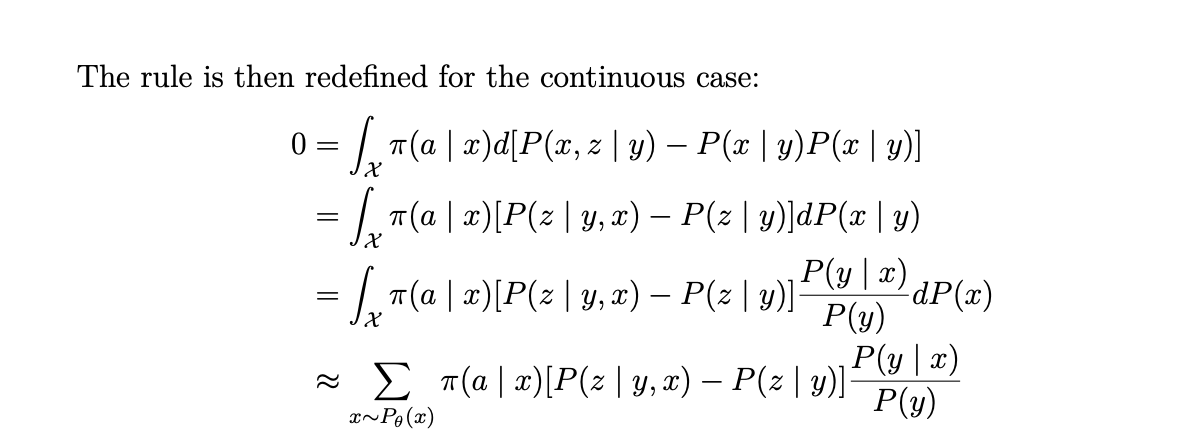

In [49]:
Py, Pz_y, model_y_x, model_z_yx

(array([0.5509915, 0.4490085]),
 array([[4.90640097e-02, 3.75925926e-02],
        [3.50694444e-01, 5.08703704e-01],
        [2.79438406e-01, 2.41666667e-01],
        [8.52958937e-02, 6.01851852e-02],
        [6.49154589e-03, 2.40740741e-03],
        [2.26449275e-03, 2.40740741e-03],
        [1.25301932e-02, 4.62962963e-03],
        [1.03411836e-01, 6.98148148e-02],
        [9.31461353e-02, 6.16666667e-02],
        [1.67572464e-02, 9.44444444e-03],
        [4.52898551e-04, 5.55555556e-04],
        [4.52898551e-04, 9.25925926e-04]]),
 LogisticRegression(max_iter=1000),
 LogisticRegression(max_iter=1000))

In [50]:
def empirical_fairness_cont_v11(datas, p_a_x, Pz_y, Py, model_y_x, model_z_yx):
    Z = n_z

    Py_x = model_y_x.predict_proba(datas[X_atr]).T
    EF = 0
    for y in range(2):
        tmp_data = datas[[Y_atr] + X_atr].copy()
        tmp_data[Y_atr] = y
        Pz_yx = model_z_yx.predict_proba(tmp_data[[Y_atr] + X_atr]).T
        print(Pz_yx.shape)
        for z in range(Z):
            c = 0
            for i in range(tmp_data.shape[0]):
                delta = (Pz_yx[z, i] - Pz_y[z, y] ) * (Py_x[y, i]/Py[y])
                c += p_a_x[:, i] * delta
            c = c/tmp_data.shape[0]
            c = np.linalg.norm(c, 1)
            EF += c
    return EF


def empirical_fairness_cont_v12(datas, p_a_x, Pz_y, Py,model_y_x, model_z_yx):
    Z = n_z

    Py_x = model_y_x.predict_proba(datas[X_atr]).T
    EF = 0
    for y in range(2):
        tmp_data = datas[[Y_atr] + X_atr].copy()
        tmp_data[Y_atr] = y
        Pz_yx = model_z_yx.predict_proba(tmp_data[[Y_atr] + X_atr]).T
        for z in range(Z):
            c = 0
            j= 0 
            for i in range(tmp_data.shape[0]):
                j = j + 1
                delta = (Pz_yx[z, i] / Pz_y[z, y] - 1 ) * (Py_x[y, i] / (Py[y]) )
                c += p_a_x[:, i] * delta
            c = c/datas.shape[0]
            c = np.linalg.norm(c, 1)
            EF += c
    return EF

In [55]:
datas = train_data
datas.shape

(6000, 10)

In [56]:
p_a1 = policy_model.predict(datas[X_atr].astype("float32"))
p_a0 = 1 - p_a1
p_a_x = np.concatenate([p_a0, p_a1],axis=1).T

188/188 [==============================] - 0s 262us/step


In [57]:
Py, Pz_y, model_y_x, model_z_yx = get_models(datas)
empirical_fairness_cont_v11(datas = datas, p_a_x = p_a_x, Pz_y=Pz_y, Py=Py, model_y_x = model_y_x, model_z_yx = model_z_yx )

(12, 6000)
(12, 6000)


0.29246787279407727

In [58]:
Py, Pz_y, model_y_x, model_z_yx = get_models(datas)
empirical_fairness_cont_v12(datas = datas,
                            p_a_x = p_a_x,
                            Pz_y = Pz_y,
                            Py = Py,
                            model_y_x = model_y_x, 
                            model_z_yx = model_z_yx )

5.384358033537865

# evaluate

In [ ]:
def get_fairness(policy, model_delta):
    (X, Y, Z) = model_delta.shape
    fairness = 0
    for y in range(Y):
        for z in range(Z):
            delta = np.matmul(policy, model_delta[:, y , z ])
            fairness += np.linalg.norm(delta, 1)
    return fairness

In [ ]:
def get_utility(policy, model, utility):
    """
    Calculate expected utility
    Todo: vectorize operation - minor
    """
    A, X = policy.shape
    Y = A
    Eu = 0
    for x in range(X):
        for y in range(Y):
            for a in range(A):
                Eu += utility[a,y] * policy[a,x] * model.Pxy[x, y]
                
    return Eu

In [ ]:
data_Py = [Py[y] for y in train_data[Y_atr].values]
data_Pz_y = [Pz_y[z, y] for z, y in train_data[[Z_atr,Y_atr]].values]

predicted_proba_Py_x = model_y_x.predict_proba(train_data[X_atr])
data_Py_z = np.zeros(train_data.shape[0])
for i, datum in train_data.iterrows():
    data_Py_z[i] = predicted_proba_Py_x[i][datum[Y_atr]]
    
predicted_proba_Pz_yx = model_z_yx.predict_proba(train_data[[Y_atr] + X_atr])
data_Pz_yx = np.zeros(train_data.shape[0])
for i, datum in train_data.iterrows():
    data_Pz_yx[i] = predicted_proba_Pz_yx[i][datum[Z_atr]]

In [ ]:
p_a_x

In [ ]:
prob_columns
p_a_x = p_a_x.T

In [ ]:
C = 0
for i, (py, pz_y, py_z, pz_yx) in enumerate(in_df[prob_columns].values): 
    delta =  (pz_yx - pz_y) * (py_z / py)
    for a in range(2):
        C += p_a_x[a,i] * np.abs(delta)

In [ ]:
C / 6000

In [ ]:
p_a_x[a,i]

In [ ]:
in_df.columns

In [ ]:
prob_columns = ['Py', 'Pz_y', 'Py_z', 'Pz_yx']
in_df[prob_columns].values

In [ ]:
pa_x

In [ ]:
data_Py_z

In [ ]:
Py, Pz_y

In [ ]:
predicted_proba_Py_x = model_y_x.predict_proba(train_data[X_atr])

In [ ]:
predicted_proba_Py_x = predicted_proba_Py_x.T

In [ ]:
predicted_proba_Pz_yx.T

In [ ]:
Pz_y[z,y]

In [ ]:
C = 0
for y in range(len(unique_y)):
    train_data[Y_atr] = y
    pz_yix = model_z_yx.predict_proba(train_data[[Y_atr] + X_atr]).T
    for z in range(len(unique_y)):
        c = 0 
        for x, p_a in enumerate(p_a_x):
            delta = (pz_yix[z, x] - Pz_y[z,y])*(predicted_proba_Py_x[y, x] / Py[y])
            delta = np.abs(delta)
            for a in range(2):
                c += p_a[a] * np.abs(delta)
        c = c
        C += c 

In [ ]:
delta

In [ ]:
c/(6000*2)

In [ ]:
p_a_x

In [ ]:
enumerate(p_a_x)

In [ ]:
p_a_x

In [ ]:
pz_yx[z,x]

In [ ]:
np.ldelta

In [ ]:
p_a1 = policy.predict(in_df[X_atr])
p_a0 = 1 - p_a1
p_a_x = np.concatenate([p_a0,p_a1],axis=1)

In [ ]:
EF = 0 
for p_a, y in zip(p_a_x, train_data[Y_atr].values):
    for a in range(2):
        EU += utility[a,y] * p_a[a]
EU = EU/train_data.shape[0]

In [ ]:
def get_empirical_fairness(policy, y_array, utility):
    EF = 0 
    for p_a, y in zip(policy, y_array):
        for a in range(2):
            EU += utility[a,y] * p_a[a]
    EU = EU/train_data.shape[0]
    return EU

In [ ]:
def get_empirical_utility2(policy, y_array, utility):
    EU = 0 
    for p_a in policy:
        for y in range(2):
            for a in range(2):
                EU += utility[a, y] * p_a[a]
    EU = EU/train_data.shape[0]
    return EU

In [ ]:
def get_empirical_utility(policy, y_array, utility):
    EU = 0 
    for p_a, y in zip(policy, y_array):
        for a in range(2):
            EU += utility[a,y] * p_a[a]
    EU = EU/train_data.shape[0]
    return EU

In [ ]:
get_empirical_utility(p_a_x,train_data[Y_atr].values,utility)

In [ ]:
get_empirical_utility2(p_a_x, train_data[Y_atr].values,utility)

In [ ]:
a = np.argmax(p_a_x,axis=1)

In [ ]:
EU = 0 
for p_a,y in zip(p_a_x, train_data[Y_atr].values):
    for a in range(2):
        EU += utility[a,y] * p_a[a]
EU = EU/train_data.shape[0]

In [ ]:
utility

In [ ]:
EU

In [ ]:
p_a_x[x, a]

In [ ]:
train_data[Y_atr]

In [ ]:
in_df

In [ ]:
policy.history

In [ ]:
policy.evaluate(test_data[X_atr].astype("float32"),
                test_data[Y_atr])

In [ ]:
tf.matmul(train_data[X_atr].astype("float32"), policy.w)

In [ ]:
policy.predict(train_data[X_atr].astype("float32"))

#### fairness functions

#### utility functions

#### opt functions

In [ ]:
def evaluate(true_model, true_model_delta, policy, utility, l):
    """
    Evaluate policy on true model
    """
    results = {}
    results["fairness"] = np.round(get_fairness(policy, true_model_delta),4)
    results["utility"] = get_utility(policy, true_model, utility)
    results["total"] = (1 - l) * results["utility"] - l * results["fairness"]
    return results

In [ ]:
def update_policy(policy, model, utility, l, lr, n_iter):
    """
    Marginal Policy Dirichlet
    """
    model.get_marginal_model()
    model_delta = get_delta(model.Px_y, model.Px_yz)
    
    for i in range(n_iter):
        fairness_gradient = get_fairness_gradient(policy, model_delta)
        utility_gradient = get_utility_gradient(policy, model, utility)
        gradient = (1 - l) * utility_gradient #+ l * fairness_gradient # minus on the gradient calc.
        gradient = project_gradient(gradient)
        policy = policy + lr * gradient # maximize Utility & minimize fairness constrain.
        policy = normilize_policy(policy)
    
    return policy

In [ ]:
def update_policy_bayesian(policy, model, utility, l, lr, n_iter, n_model):
    """
    Marginal Policy Dirichlet
    """
    models = []
    model_delta = []
    for m in range(n_model):
        models += [model.sample_model()]
        model_delta += [get_delta(model.Px_y, model.Px_yz)]
    
    for i in range(n_iter):
        tmp_index = i%n_model
        tmp_model = models[tmp_index]
        tmp_delta = model_delta[tmp_index]
        fairness_gradient = get_fairness_gradient(policy, tmp_delta)
        utility_gradient = get_utility_gradient(policy, tmp_model, utility)
        gradient = (1 - l) * utility_gradient + l * fairness_gradient # minus on the gradient calc.
        gradient = project_gradient(gradient)
        policy = policy + lr * gradient # maximize Utility & minimize fairness constrain.
        policy = normilize_policy(policy)
    
    return policy

In [ ]:
# reproduce results
stop

In [ ]:
def load_org_policy(org_path_results):
    file = pd.read_csv(org_path_results + "/policy.csv")
    p_1 = file.iloc[4].values
    p_2 = file.iloc[5].values
    p_1 = [float(x) for x in p_1[0].split(" ")[1:]]
    p_2 = [float(x) for x in p_2[0].split(" ")[1:]]
    return np.array([p_1, p_2])
# [float(x) for x in p_1[0].split(" ")[1:]]

In [ ]:
org_path_results = "/Users/andreasathanasopoulos/Phd/projects/bayesian_fairness/org_code/bayesian-fairness/src/octave"
policy = load_org_policy(org_path_results)
policy.shape

In [ ]:
l

In [ ]:
steps = horizon // update_policy_period

results = []
for step in range(steps):    
    # update policy step
    policy = update_policy_bayesian(policy, belief, utility, l, lr, n_iter, n_model= n_samples) # SDG to update policy
    
    # evaluation step
    step_results = evaluate(true_dirichlet_model, true_model_delta, policy, utility, l)
    results += [step_results]
    
    # update belief step
    data_start_index = step * update_policy_period
    data_stop_index = min(data_start_index + update_policy_period, horizon)
    belief.update_posterior_belief(train_data.iloc[data_start_index : data_stop_index])
    
    print(f"--- Step : {data_start_index + 1} \n  ------- {step_results}")
    

In [ ]:
pd_resutls = pd.DataFrame(results)

# plots

In [ ]:
pd_resutls[["utility"]].plot()

In [ ]:
org = pd.read_csv(org_path_results + "/results.csv")

In [ ]:
def fix_results(r):
    new_r = [float(sr.split(" ")[1]) for sr in r]
    return new_r

r1 = fix_results(org.iloc[9: 64 + 9 - 3]["# Created by Octave 6.2.0"].values)
r2 = fix_results(org.iloc[74: 64 + 74 - 3]["# Created by Octave 6.2.0"].values)
r3 = fix_results(org.iloc[139: 64 + 139 - 3]["# Created by Octave 6.2.0"].values)
# r4 = fix_results(org.iloc[204: 64 + 204]["# Created by Octave 6.2.0"].values)

org_pd = pd.DataFrame([r1,r2,r3]).T
org_pd.columns = ["utility","total","fairness"]

In [ ]:
org_pd

In [ ]:
org_pd["utility"].plot()
pd_resutls["utility"].plot()

In [ ]:
org_pd["fairness"].plot()
pd_resutls["fairness"].plot()

In [ ]:
org_pd["total"].plot()
pd_resutls["total"].plot()

# Questions

In [ ]:
1. ProjectPolicyGradient ???